In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
import scipy
import random
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import os
import shutil

In [14]:
def correlation_pearson(X, Y, moyX, moyY, ecart_typeX, ecart_typeY):
    n = len(X)
    corr = 0
    for xi, yi in zip(X, Y):
        corr  += (xi-moyX)*(yi-moyY)
    return corr/((n-1)*ecart_typeX*ecart_typeY)

def distance_minkowski(X, Y, D, K):
    distance = 0
    for i in range(D):
        distance += pow(abs(X[i]-Y[i]), K)
    return pow(distance, 1/K)

def calcul_k_means(points, centroides, dimension):
    clusters = {k+1: [] for k in range(len(centroides))}
    centroides_prime = []
    
    for point in points:
        mini_local, bary = distance_minkowski(point[:-1], centroides[0], dimension, 2), 1
        for k in range(len(centroides)):
            dist = distance_minkowski(point[:-1], centroides[k], dimension, 2)
            if dist < mini_local:
                mini_local, bary = dist, k+1
        clusters[bary].append(point)
        
    for bary, all_points in clusters.items():
        if len(all_points) > 0:
            coord = []
            for D in range(dimension):
                moyenne_dim = 0
                for point in all_points:
                    moyenne_dim += point[D]
                moyenne_dim = moyenne_dim/len(all_points)
                coord.append(moyenne_dim)
            centroides_prime.append(coord)
    
    if centroides == centroides_prime:
        return centroides_prime, clusters
    
    else:
        return calcul_k_means(points, centroides_prime, dimension)
    
def proportion_clusters(clusters, structure):
    proportion = {i+1 : {} for i in range(len(clusters.keys()))}
    k = 1
    for bary, all_points in clusters.items():
        bilan = {stru: 0 for stru in structure}
        for point in all_points:
            bilan[point[-1]] += 1
        total = sum(bilan.values())
        for stru, prop in bilan.items():
            proportion[k][stru] = prop
        k += 1
    return proportion

def qualite_clusters(barycentres, clusters):
    qualite = {i+1: {} for i in range(len(barycentres))}
    k = 1
    for bar, points in zip(barycentres, clusters.values()):
        homogeneite = 0
        for point in points:
            homogeneite += distance_minkowski(bar, point[:-1], len(bar), 2)
        homogeneite /= len(points)
        qualite[k]["Homogeneite"] = homogeneite
        k += 1
    
    for i in range(len(barycentres)):
        separabilite, qualite[i+1]["Cluster"] = 0, 0
        for j in range(len(barycentres)):
            if i != j:
                separabilite = distance_minkowski(barycentres[i], barycentres[j], len(barycentres[i]), 2)
                qualite[i+1]["Cluster"] = max(qualite[i+1]["Cluster"], (qualite[i+1]["Homogeneite"]+qualite[j+1]["Homogeneite"])/separabilite) 
            
    qualite_clustering = 0
    
    for bar in qualite.keys():
        qualite_clustering += qualite[bar]["Cluster"]
        
    return qualite_clustering/len(barycentres)

def calcul_cah(dissimilarite, identite):
    if dissimilarite.shape[0] <= 1:
        return identite[0]
    minimum = np.inf
    c1, c2 = 0, 0
    for i in range(dissimilarite.shape[0]-1):
        for j in range(i+1, dissimilarite.shape[0]):
            if minimum > dissimilarite[i, j]:
                minimum = dissimilarite[i, j]
                c1, c2 = i, j
    nouveau = []
    rajout = [max(dissimilarite[c1, c2], dissimilarite[c1, c1], dissimilarite[c2, c2])]
    for i in range(dissimilarite.shape[0]):
        if i != c1 and i != c2:
            nouveau.append(max(dissimilarite[i, c1], dissimilarite[i, c2]))

    dissimilarite = np.delete(dissimilarite, max(c1, c2), axis=0)
    dissimilarite = np.delete(dissimilarite, max(c1, c2), axis=1)
    dissimilarite = np.delete(dissimilarite, min(c1, c2), axis=0)
    dissimilarite = np.delete(dissimilarite, min(c1, c2), axis=1)
    dissimilarite = np.column_stack([dissimilarite, nouveau])
    dissimilarite = np.vstack([dissimilarite, nouveau+rajout])
    
    cluster = f"({identifiant[c1]}: {round(minimum, 2)}, {identifiant[c2]}: {round(minimum, 2)})"
    
    identifiant.pop(max(c1, c2))
    identifiant.pop(min(c1, c2))
    identifiant.append(cluster)
    
    return calcul_cah(dissimilarite, identifiant)

def alignement_distance(sequence1, sequence2, identite, matrice_distance_AA, AA_indice, gap):
    lignes, colonnes = len(sequence1)+1, len(sequence2)+1
    matrice = np.zeros((lignes, colonnes))

    for i in range(1, lignes):
        matrice[i, 0] = matrice[i-1, 0] + gap

    for i in range(1, colonnes):
        matrice[0, i] = matrice[0, i-1] + gap

    for i in range(1, lignes):
        for j in range(1, colonnes):
            haut_gauche = matrice[i-1, j-1]
            gauche = matrice[i, j-1]
            haut = matrice[i-1, j]
            if sequence1[i-1] == sequence2[j-1]:
                matrice[i, j] = min(haut_gauche+identite, gauche+gap, haut+gap)
            else:
                matrice[i, j] = min(haut_gauche-matrice_distance_AA[AA_indice[sequence1[i-1]], AA_indice[sequence2[j-1]]], gauche+gap, haut+gap)

    return matrice[lignes-1, colonnes-1]

def knn(x, k, points):
    all_distance = []
    compte = {"HELIX": 0, "SHEET": 0}
    for p in range(len(points)):
        all_distance.append((distance_minkowski(points[p][:-2], x, len(x), 2), points[p][-2], points[p][-1]))
    all_distance = sorted(all_distance)
    for p in range(k):
        compte[all_distance[p][-1]] += 1
    return max(compte, key=lambda k: compte[k]), list(all_distance[:k+100])

def prediction_arbre(arbre, tup):
    if type(arbre) == str:
        return arbre
    try:
        var = list(arbre.keys())[0]
        arbre = arbre[var]
        arbre = arbre[tup[var]]
        return prediction_arbre(arbre, tup)
    except KeyError:
        return "Vide"
    
def calcul(datafr, variable, colonnes, anciens, arbre):
    entropie_global, cpt = 0, 0
    save_data = datafr.copy()
    if anciens == []:
        classes = datafr[variable].unique()
        freq = datafr[variable].value_counts()
        total = sum(freq)
        entropie_global = 0
        for c in classes:
            entropie_global += freq[c] / total * math.log2(freq[c] / total)
        entropie_global *= -1
    else:
        for contenu in anciens:
            datafr = datafr.loc[datafr[contenu[0]] == contenu[1]]
        classes = datafr[variable].unique()
        freq = datafr[variable].value_counts()
        total = sum(freq)
        entropie_global = 0
        for c in classes:
            entropie_global += freq[c] / total * math.log2(freq[c] / total)
        entropie_global *= -1
    maxi, noeud = 0, ""
    entropie = {}
    for col in colonnes:
        entropie[col] = {}
        entropie_col = 0 + entropie_global
        classes = datafr[col].unique()
        entropie_local = {c:0 for c in classes}
        freq = datafr[col].value_counts()
        prob = {c: freq[c]/sum(freq) for c in classes}
        for c in classes:
            ss_df = datafr.loc[datafr[col] == c, [variable]]
            ss_freq = ss_df[variable].value_counts()
            ss_classe = list(ss_freq.keys())
            if len(ss_freq) != 1:
                for cl in ss_classe:
                    entropie_local[c] -= ss_freq[cl]/freq[c]*math.log2(ss_freq[cl]/freq[c])
                entropie[col][c] = entropie_local[c]
            else:
                entropie[col][c] = (entropie_local[c], list(dict(ss_freq).keys())[0])
        for cl, ent in entropie_local.items():
            entropie_col -= prob[cl]*ent
        if entropie_col > maxi or cpt == 0:
            cpt += 1
            maxi, noeud = entropie_col, col
    colonnes.remove(noeud)
    arbre[noeud] = {}
    for classe in entropie[noeud].keys():
        if type(entropie[noeud][classe]) == tuple:
            arbre[noeud][classe] = entropie[noeud][classe][-1]
        elif colonnes != []:
            ss_arbre = calcul(save_data, variable, colonnes, anciens+[(noeud, classe)], {})
            arbre[noeud][classe] = ss_arbre
        else:
            occur = ss_freq.to_dict()
            arbre[noeud][classe] = max(occur, key=occur.get)
    return arbre

def tuple_amine(en_compte, variables, precedent, dernierAA, qualitatif_AA, prediction):
    dataF = dict()
    colonnes = list(precedent.keys())
    transition = colonnes.copy()
    transition.remove("Structure(n-1)")
    for col, val in zip(transition, list(precedent.values())[len(variables)+2:]):
        if "Pi(" in col:
            dataF["Structure(n-1)"] = prediction
        dataF[col] = val
    colonnes = colonnes[len(list(precedent.values())[len(variables)+2:])+1:]
    if dernierAA == "Vide":
        for col in colonnes:
            dataF[col] = "Vide"
    else:
        for col in colonnes[:-1]:
            trim = col.split("(")[0]
            dataF[col] = quali_AA[dernierAA][trim]
        dataF[colonnes[-1]] = dernierAA
    return dataF

def tuple_proteine(en_compte, pid, qualitatif_AA, variables):
    colonnes = []
    for i in range(en_compte, 0, -1):
        for var in variables:
            colonnes.append(f"{var}(n-{i})")
        colonnes += [f"Structure(n-{i})", f"AA(n-{i})"]
    for var in variables:
        colonnes.append(f"{var}(n)")
    colonnes.append("AA(n)")
    for i in range(1, en_compte+1):
        for var in variables:
            colonnes.append(f"{var}(n+{i})")
        colonnes.append(f"AA(n+{i})")
    with open(f"Sequence TEST/{pid}.txt", "r") as filseq:
        filseq.readline()
        seq = filseq.readline()
        structure = ["Vide" for _ in range(len(seq))]
    with open(f"Structure secondaire TEST/{pid}.txt", "r") as filstr:
        for ligne in filstr:
            ligne = ligne[:-1].split(';')
            if ligne[0] == "HELIX" and len(ligne) == 11 and ligne[4] == "A":
                debut, fin = int(ligne[5]), int(ligne[8])
                if debut < fin and debut < len(seq) and fin < len(seq):
                    for i in range(debut-1, fin):
                        structure[i] = "Structure"
            elif ligne[0] == "SHEET" and len(ligne) == 19 and ligne[5] == "A":
                debut, fin = int(ligne[6]), int(ligne[9])
                if debut < fin and debut < len(seq) and fin < len(seq):
                    for i in range(debut-1, fin):
                        structure[i] = "Structure"
    structure_predite = []
    precedent = dict()
    cpt = 0
    for col in colonnes:
        if "-" in col:
            precedent[col] = "Vide"
        elif "+" in col:
            trim = col.split("(")[0]
            if trim == "AA":
                precedent[col] = seq[cpt]
                cpt += 1
            else:
                precedent[col] = qualitatif_AA[seq[cpt]][trim]
        else:
            trim = col.split("(")[0]
            if trim == "AA":
                precedent[col] = seq[cpt]
                cpt += 1
            else:
                precedent[col] = qualitatif_AA[seq[cpt]][trim]
    prediction = prediction_arbre(decision, precedent)
    structure_predite.append(prediction)
    for i in range(1, len(seq)):
        if i+en_compte >= len(seq):
            limite_AA = "Vide"
        else:
            limite_AA = seq[i+en_compte]
        precedent = tuple_amine(en_compte, variables, precedent, limite_AA, qualitatif_AA, prediction)
        prediction = prediction_arbre(decision, precedent)
        structure_predite.append(prediction)
    return structure_predite, structure, seq

def tuple_proteine_mutation(en_compte, pid, qualitatif_AA, variables, acide_amine, position):
    colonnes = []
    for i in range(en_compte, 0, -1):
        for var in variables:
            colonnes.append(f"{var}(n-{i})")
        colonnes += [f"Structure(n-{i})", f"AA(n-{i})"]
    for var in variables:
        colonnes.append(f"{var}(n)")
    colonnes.append("AA(n)")
    for i in range(1, en_compte+1):
        for var in variables:
            colonnes.append(f"{var}(n+{i})")
        colonnes.append(f"AA(n+{i})")
    with open(f"Sequence TEST/{pid}.txt", "r") as filseq:
        filseq.readline()
        seq = filseq.readline()
        structure = ["Vide" for _ in range(len(seq))]
    with open(f"Structure secondaire TEST/{pid}.txt", "r") as filstr:
        for ligne in filstr:
            ligne = ligne[:-1].split(';')
            if ligne[0] == "HELIX" and len(ligne) == 11 and ligne[4] == "A":
                debut, fin = int(ligne[5]), int(ligne[8])
                if debut < fin and debut < len(seq) and fin < len(seq):
                    for i in range(debut-1, fin):
                        structure[i] = "Structure"
            elif ligne[0] == "SHEET" and len(ligne) == 19 and ligne[5] == "A":
                debut, fin = int(ligne[6]), int(ligne[9])
                if debut < fin and debut < len(seq) and fin < len(seq):
                    for i in range(debut-1, fin):
                        structure[i] = "Structure"
    structure_predite = []
    precedent = dict()
    cpt = 0
    seq = seq[:position] + acide_amine + seq[position+1:]
    for col in colonnes:
        if "-" in col:
            precedent[col] = "Vide"
        elif "+" in col:
            trim = col.split("(")[0]
            if trim == "AA":
                precedent[col] = seq[cpt]
                cpt += 1
            else:
                precedent[col] = qualitatif_AA[seq[cpt]][trim]
        else:
            trim = col.split("(")[0]
            if trim == "AA":
                precedent[col] = seq[cpt]
                cpt += 1
            else:
                precedent[col] = qualitatif_AA[seq[cpt]][trim]
    prediction = prediction_arbre(decision, precedent)
    structure_predite.append(prediction)
    for i in range(1, len(seq)):
        if i+en_compte >= len(seq):
            limite_AA = "Vide"
        else:
            limite_AA = seq[i+en_compte]
        precedent = tuple_amine(en_compte, variables, precedent, limite_AA, qualitatif_AA, prediction)
        prediction = prediction_arbre(decision, precedent)
        structure_predite.append(prediction)
    return structure_predite, structure, seq

def trouver_sequences_contigues(liste_de_nombres):
    sequences_contigues = []
    sequence_en_cours = []

    for nombre in liste_de_nombres:
        if not sequence_en_cours or nombre == sequence_en_cours[-1] + 1:
            sequence_en_cours.append(nombre)
        else:
            sequences_contigues.append(sequence_en_cours)
            sequence_en_cours = [nombre]
            
    if sequence_en_cours:
        sequences_contigues.append(sequence_en_cours)

    return sequences_contigues

def creation_df_train(en_compte, nom):
    
    with open(f"{nom}.txt", "w") as filout:
        texte = ""
        for i in range(en_compte, 0, -1):
            for var in variables:
                texte += f"{var}(n-{i});"
            texte += f"Structure(n-{i});AA(n-{i});"
        for var in variables:
            texte += f"{var}(n);"
        texte += "AA(n);"
        for i in range(1, en_compte+1):
            for var in variables:
                texte += f"{var}(n+{i});"
            texte += f"AA(n+{i});"
        texte += "Structure(n)\n"
        for fic in os.listdir("Sequence"):
            pid = fic[:-4]
            with open(f"Sequence/{pid}.txt", "r") as filseq:
                filseq.readline()
                seq = filseq.readline()
                structure = ["Vide" for _ in range(len(seq))]
                with open(f"Structure secondaire/{pid}.txt", "r") as filstr:
                    for ligne in filstr:
                        ligne = ligne[:-1].split(';')
                        if ligne[0] == "HELIX" and len(ligne) == 11 and ligne[4] == "A":
                            debut, fin = int(ligne[5]), int(ligne[8])
                            if debut < fin and debut < len(seq) and fin < len(seq):
                                for i in range(debut-1, fin):
                                    structure[i] = "Structure"
                        elif ligne[0] == "SHEET" and len(ligne) == 19 and ligne[5] == "A":
                            debut, fin = int(ligne[6]), int(ligne[9])
                            if debut < fin and debut < len(seq) and fin < len(seq):
                                for i in range(debut-1, fin):
                                    structure[i] = "Structure"
                ss_texte = ""
                for n in range(len(seq)):
                    for i in range(en_compte, 0, -1):
                        if n-i < 0:
                            for var in variables:
                                ss_texte += "Vide;"
                            ss_texte += "Vide;Vide;"
                        else:
                            for var in variables:
                                ss_texte += quali_AA[seq[n-i]][var] + ";"
                            ss_texte += structure[n-i] + f";{seq[n-i]};"
                    for var in variables:
                        ss_texte += quali_AA[seq[n]][var] + ";"
                    ss_texte += f"{seq[n]};"
                    for i in range(1, en_compte+1):
                        if n+i >= len(seq):
                            for var in variables:
                                ss_texte += "Vide;"
                            ss_texte += "Vide;"
                        else:
                            for var in variables:
                                ss_texte += quali_AA[seq[n+i]][var] + ";"
                            ss_texte += f"{seq[n+i]};"
                    ss_texte += structure[n] + "\n"
                texte += ss_texte
        filout.write(texte)

def creation_df_test(nom, en_compte):
    with open(f"{nom}.txt", "w") as filout:
        texte = ""
        for i in range(en_compte, 0, -1):
            for var in variables:
                texte += f"{var}(n-{i});"
            texte += f"Structure(n-{i});AA(n-{i});"
        for var in variables:
            texte += f"{var}(n);"
        texte += "AA(n);"
        for i in range(1, en_compte+1):
            for var in variables:
                texte += f"{var}(n+{i});"
            texte += f"AA(n+{i});"
        texte += "Structure(n)\n"
        for fic in os.listdir("Sequence TEST"):
            pid = fic[:-4]
            with open(f"Sequence TEST/{pid}.txt", "r") as filseq:
                filseq.readline()
                seq = filseq.readline()
                structure = ["Vide" for _ in range(len(seq))]
                with open(f"Structure secondaire TEST/{pid}.txt", "r") as filstr:
                    for ligne in filstr:
                        ligne = ligne[:-1].split(';')
                        if ligne[0] == "HELIX" and len(ligne) == 11 and ligne[4] == "A":
                            debut, fin = int(ligne[5]), int(ligne[8])
                            if debut < fin and debut < len(seq) and fin < len(seq):
                                for i in range(debut-1, fin):
                                    structure[i] = "Structure"
                        elif ligne[0] == "SHEET" and len(ligne) == 19 and ligne[5] == "A":
                            debut, fin = int(ligne[6]), int(ligne[9])
                            if debut < fin and debut < len(seq) and fin < len(seq):
                                for i in range(debut-1, fin):
                                    structure[i] = "Structure"
                ss_texte = ""
                for n in range(len(seq)):
                    for i in range(en_compte, 0, -1):
                        if n-i < 0:
                            for var in variables:
                                ss_texte += "Vide;"
                            ss_texte += "Vide;Vide;"
                        else:
                            for var in variables:
                                ss_texte += quali_AA[seq[n-i]][var] + ";"
                            ss_texte += structure[n-i] + f";{seq[n-i]};"
                    for var in variables:
                        ss_texte += quali_AA[seq[n]][var] + ";"
                    ss_texte += f"{seq[n]};"
                    for i in range(1, en_compte+1):
                        if n+i >= len(seq):
                            for var in variables:
                                ss_texte += "Vide;"
                            ss_texte += "Vide;"
                        else:
                            for var in variables:
                                ss_texte += quali_AA[seq[n+i]][var] + ";"
                            ss_texte += f"{seq[n+i]};"
                    ss_texte += structure[n] + "\n"
                texte += ss_texte
        filout.write(texte)

def creation_foret(comptes, tailles, nom):
    path = f"Zone/{nom}"
    if nom in os.listdir("Zone"):
        shutil.rmtree(path)
    os.mkdir(path)
    os.mkdir(f"{path}/Entrainement")
    foret = []
    num = 0
    creation_df_test(f"{path}/df_test", int(max(comptes)))
    texte = "Compte;Taille_app\n"
    for cpt, taille in zip(comptes, tailles):
        num += 1
        texte += f"{cpt};{taille}\n"
        creation_df_train(cpt, f"{path}/Entrainement/train_{num}")
        df_apprentissage = pd.read_csv(f"{path}/Entrainement/train_{num}.txt", sep=";", keep_default_na=False, low_memory=False).sample(n=taille).reset_index(drop=True)
        explication = df_apprentissage.columns[-1]
        colonnes = list(df_apprentissage.columns[:-1])
        foret.append(calcul(df_apprentissage, explication, colonnes, [], {}))
    with open(f"{path}/parametres.txt", "w") as filout:
        filout.write(texte)
    return foret

def resultat_foret_individuelle(foret, nom):
    path = f"Zone/{nom}"
    texte = "Numero;Erreur_structure;Erreur_non_structure;Total\n"
    num = 0
    df_test = pd.read_csv(f"{path}/df_test.txt", sep=";", keep_default_na=False, low_memory=False)
    for arbre in foret:
        num += 1
        erreur_structure = 0
        erreur_non_structure = 0
        for _, tup in df_test.iterrows():
            pred = prediction_arbre(arbre, tup)
            if pred != tup["Structure(n)"]:
                if tup["Structure(n)"] == "Structure":
                    erreur_structure += 1
                else:
                    erreur_non_structure += 1
        pour_total  = round((erreur_structure+erreur_non_structure)/sum(df_test_structure["Structure(n)"].value_counts())*100, 2)
        pour_non_structure = round(erreur_non_structure/df_test_structure["Structure(n)"].value_counts()["Vide"]*100, 2)
        pour_structure = round(erreur_structure/df_test_structure["Structure(n)"].value_counts()["Structure"]*100, 2)
        texte += f"{num};{pour_structure};{pour_non_structure};{pour_total}\n"
        with open(f"{path}/performance_individuelle.txt", 'w') as filout:
            filout.write(texte)
    return f"{path}/performance_individuelle.txt"

def resultat_foret_total(foret, nom):
    path = f"Zone/{nom}"
    df_test = pd.read_csv(f"{path}/df_test.txt", sep=";", keep_default_na=False, low_memory=False)
    erreur_structure = 0
    erreur_non_structure = 0
    for _, tup in df_test.iterrows():
        prediction = []
        for arbre in foret:
            prediction.append(prediction_arbre(arbre, tup))
        pred = max(prediction, key=prediction.count)
        if pred != tup["Structure(n)"]:
            if tup["Structure(n)"] == "Structure":
                erreur_structure += 1
            else:
                erreur_non_structure += 1
    pour_total  = round((erreur_structure+erreur_non_structure)/sum(df_test_structure["Structure(n)"].value_counts())*100, 2)
    pour_non_structure = round(erreur_non_structure/df_test_structure["Structure(n)"].value_counts()["Vide"]*100, 2)
    pour_structure = round(erreur_structure/df_test_structure["Structure(n)"].value_counts()["Structure"]*100, 2)
    
    texte = f"Structure: {pour_structure}, Non Structure: {pour_non_structure}, Total: {pour_total}"
    
    with open(f"{path}/performance_globale.txt", 'w') as filout:
        filout.write(texte)
    
    return texte

In [3]:
class Analyse:
    def __init__(self, nom,data):
        self.nom = nom
        self.data = data
        self.replicat = len(data)
        self.somme = round(sum(data), 4)
    
    @property
    def moyenne(self):
        return round(self.somme/self.replicat, 4)
    @property
    def variance(self):
        var = 0
        for i in self.data:
            var += math.pow(i-self.moyenne, 2)
        return round(var/(self.replicat-1), 4)
    @property
    def ecart_type(self):
        return round(math.sqrt(self.variance), 4)
    @property
    def mediane(self):
        return round(np.percentile(self.data, 50), 4)
    @property
    def quartile_1(self):
        return round(np.percentile(self.data, 25), 4)
    @property
    def quartile_3(self):
        return round(np.percentile(self.data, 75), 4)
    @property
    def iqr(self):
        return round(self.quartile_3 - self.quartile_1, 4)
    @property
    def borne_superieur_iqr(self):
        return round(min(max(self.data), self.quartile_3 + 1.5*self.iqr), 4)
    @property
    def borne_inferieur_iqr(self):
        return round(max(min(self.data), self.quartile_1 - 1.5*self.iqr), 4)
    @property
    def outsider(self):
        out = []
        for i in self.data:
            if not self.borne_inferieur_iqr <= i <= self.borne_superieur_iqr:
                out.append(i)
        return out
    @property
    def borne_inf_ic_95(self):
        return round(self.moyenne - scipy.stats.norm.ppf(1-0.05/2)*(self.ecart_type/math.sqrt(self.replicat)), 4)
    @property
    def borne_sup_ic_95(self):
        return round(self.moyenne + scipy.stats.norm.ppf(1-0.05/2)*(self.ecart_type/math.sqrt(self.replicat)), 4)
    @property
    def ecart_moyen_absolu(self):
        ecart = 0
        for i in range(self.replicat):
            ecart += abs(self.data[i]-self.moyenne)
        return round(ecart/self.replicat, 4)
    @property
    def mad(self):
        Y = [0 for _ in range(self.replicat)]
        for i in range(self.replicat):
            Y[i] = abs(self.mediane-self.data[i])
        return round(np.percentile(Y, 50), 4)

In [4]:
AA = {}

with open("colonnes.txt", "r") as fil:
    col = fil.readline().split(',')

with open("AA.txt", "r") as fil:
    for ligne in fil:
        caracteristiques = ligne[:-1].split(";")
        acide_amine = caracteristiques[1]
        caracteristiques = caracteristiques[2:]
        AA[acide_amine] = {}
        for val, car in zip(caracteristiques, col):
            AA[acide_amine][car] = float(val)

In [5]:
df = pd.read_csv("structure_secondaire.csv")
df = df[df["Sequence"].apply(len) > 2].copy()
df

,Polarite,Charge,Volume,Tendance helice,Tendance feuillet,Flexibilite,Hydropathie,Pi,Taille,Structure,Type,Sequence
0,0.7229,0.0000,16.7457,0.9113,1.2096,0.4300,1.6714,5.9386,7,HELIX,D-alpha,IGVPMTL
1,11.9777,0.0769,14.8477,1.0952,1.0530,0.4315,0.3154,6.2546,13,HELIX,D-alpha,GKTSVKEMTAAIL
2,38.2150,0.2500,14.3600,1.0262,0.8508,0.4875,-3.1500,7.2325,4,HELIX,D-310,DTRK
3,1.2800,0.0000,20.3667,1.0377,1.2777,0.3667,0.5333,5.8433,3,HELIX,D-310,YWL
4,13.6792,-0.0833,16.6475,1.0461,0.9537,0.4417,-0.6083,5.7375,12,HELIX,D-alpha,NPQDFRTLLELT
...,...,...,...,...,...,...,...,...,...,...,...,...
1686,0.7867,0.0000,21.6033,1.0233,1.7453,0.3633,2.5000,5.8967,3,SHEET,parallele,VVW
1687,0.1300,0.0000,21.4567,0.9987,1.8543,0.4367,4.4000,5.9800,3,SHEET,parallele,IIV
1689,13.1500,0.2500,13.2325,1.1907,0.8920,0.4100,-0.2500,6.7900,4,HELIX,D-310,KSMA
1690,7.0129,-0.1176,15.0888,1.0188,1.1236,0.4376,0.3529,5.3953,17,HELIX,D-alpha,AFVNNISDSVSFIEQSM


In [6]:
table_erreur = pd.read_csv("erreur.txt", sep=";")
table_erreur = table_erreur.sort_values(by=["Pourcentage erreur"])
table_erreur = table_erreur[(table_erreur["Pourcentage erreur"] < 20)]
table_erreur

,Pourcentage erreur,Voisin,Dimension
5548,18.09,1,"('Taille', 'Charge', 'Tendance helice', 'Tenda..."
7942,18.42,1,"('Taille', 'Charge', 'Tendance helice', 'Tenda..."
7923,18.75,1,"('Taille', 'Charge', 'Tendance helice', 'Tenda..."
5535,19.08,7,"('Taille', 'Charge', 'Tendance helice', 'Tenda..."
5928,19.08,1,"('Taille', 'Tendance helice', 'Tendance feuill..."
5339,19.08,1,"('Taille', 'Charge', 'Volume', 'Tendance helic..."
5567,19.08,1,"('Taille', 'Charge', 'Tendance helice', 'Tenda..."
5155,19.41,7,"('Taille', 'Polarite', 'Tendance helice', 'Ten..."
5163,19.41,15,"('Taille', 'Polarite', 'Tendance helice', 'Ten..."
2503,19.41,15,"('Taille', 'Polarite', 'Tendance helice', 'Ten..."


In [7]:
test = pd.read_csv("structure_secondaire_test.csv")
test = test[test["Sequence"].apply(len) > 2].copy()
test

,Polarite,Charge,Volume,Tendance helice,Tendance feuillet,Flexibilite,Hydropathie,Pi,Taille,Structure,Type,Sequence
0,20.7840,0.0000,12.1040,1.0344,0.8930,0.4780,-1.2800,6.2220,5,SHEET,anti-parallele,FESGR
1,2.0167,0.0000,10.7150,0.8175,0.8032,0.4933,-2.0000,5.7183,6,SHEET,anti-parallele,QTNGGQ
2,17.6667,-0.3333,12.6067,0.7840,0.8125,0.4767,-2.2500,4.7067,6,SHEET,anti-parallele,DYDGYN
3,36.6271,-0.1429,13.9300,1.1354,0.8457,0.4743,-2.6143,5.9543,7,SHEET,anti-parallele,TMDERDR
4,7.9671,0.1429,18.1600,0.9201,1.3900,0.4643,1.5000,6.6543,7,SHEET,anti-parallele,PSRIVVI
...,...,...,...,...,...,...,...,...,...,...,...,...
350,9.5864,-0.1818,16.0891,1.1296,1.0430,0.4282,0.8000,5.4055,11,HELIX,D-alpha,PETLAESFIAV
351,17.4817,-0.3333,15.1233,1.3767,0.8590,0.4200,-0.5000,4.9683,6,HELIX,D-alpha,EQMAEL
352,9.8212,0.0625,15.9088,1.1376,1.0677,0.4087,0.7500,6.2294,16,HELIX,D-alpha,ITVARPYAKAAFDFAV
353,0.1300,0.0000,21.4567,1.0763,1.6750,0.4067,4.1667,5.9667,3,SHEET,anti-parallele,VLI


In [8]:
variables = ["Taille", "Polarite", "Charge", "Volume", "Tendance helice", "Tendance feuillet", "Flexibilite", "Hydropathie", "Pi"]

In [9]:
HELIX = {}

for var in variables:
    HELIX[var] = Analyse(f"HELIX_{var}", list(i[0] for i in df.loc[df["Structure"] == "HELIX", [var]].values.tolist()))

In [10]:
SHEET = {}

for var in variables:
    SHEET[var] = Analyse(f"SHEET_{var}", list(i[0] for i in df.loc[df["Structure"] == "SHEET", [var]].values.tolist()))

In [13]:
for nom, var in HELIX.items():
    print(f"Helix({nom})")
    print(f"- Replicat: {var.replicat}\n- Somme: {var.somme}\n- Moyenne: {var.moyenne}\n- Mediane: {var.mediane}")
    print(f"- Variance: {var.variance}\n- Ecart-type: {var.ecart_type}")
    print(f"- Ecart Moyen Absolu: {var.ecart_moyen_absolu}")
    print(f"- Mediane Absolute Deviation: {var.mad}")
    print(f"- Quartile(1): {var.quartile_1}\n- Quartile(3): {var.quartile_3}\n- IQR: {var.iqr}")
    print(f"- IQR borne superieur: {var.borne_superieur_iqr}\n- IQR borne inferieur: {var.borne_inferieur_iqr}")
    print(f"- Outsider: {len(var.outsider)}")
    print(f"- Borne superieur IC 95% (si loi normale): {var.borne_sup_ic_95}")
    print(f"- Borne inferieur IC 95% (si loi normale): {var.borne_inf_ic_95}\n")

Helix(Taille)
- Replicat: 879
- Somme: 8557
- Moyenne: 9.7349
- Mediane: 9.0
- Variance: 26.3727
- Ecart-type: 5.1354
- Ecart Moyen Absolu: 4.0301
- Mediane Absolute Deviation: 4.0
- Quartile(1): 5.0
- Quartile(3): 13.0
- IQR: 8.0
- IQR borne superieur: 25.0
- IQR borne inferieur: 3
- Outsider: 9
- Borne superieur IC 95% (si loi normale): 10.0744
- Borne inferieur IC 95% (si loi normale): 9.3954

Helix(Polarite)
- Replicat: 879
- Somme: 12390.0798
- Moyenne: 14.0957
- Mediane: 13.545
- Variance: 63.1374
- Ecart-type: 7.9459
- Ecart Moyen Absolu: 6.1968
- Mediane Absolute Deviation: 4.885
- Quartile(1): 9.2184
- Quartile(3): 19.0235
- IQR: 9.8051
- IQR borne superieur: 33.7312
- IQR borne inferieur: 0.0217
- Outsider: 12
- Borne superieur IC 95% (si loi normale): 14.621
- Borne inferieur IC 95% (si loi normale): 13.5704

Helix(Charge)
- Replicat: 879
- Somme: -23.0929
- Moyenne: -0.0263
- Mediane: 0.0
- Variance: 0.0269
- Ecart-type: 0.164
- Ecart Moyen Absolu: 0.1221
- Mediane Absolute

In [14]:
for nom, var in SHEET.items():
    print(f"Sheet({nom})")
    print(f"- Replicat: {var.replicat}\n- Somme: {var.somme}\n- Moyenne: {var.moyenne}\n- Mediane: {var.mediane}")
    print(f"- Variance: {var.variance}\n- Ecart-type: {var.ecart_type}")
    print(f"- Ecart Moyen Absolu: {var.ecart_moyen_absolu}")
    print(f"- Mediane Absolute Deviation: {var.mad}")
    print(f"- Quartile(1): {var.quartile_1}\n- Quartile(3): {var.quartile_3}\n- IQR: {var.iqr}")
    print(f"- IQR borne superieur: {var.borne_superieur_iqr}\n- IQR borne inferieur: {var.borne_inferieur_iqr}")
    print(f"- Outsider: {len(var.outsider)}")
    print(f"- Borne superieur IC 95% (si loi normale): {var.borne_sup_ic_95}")
    print(f"- Borne inferieur IC 95% (si loi normale): {var.borne_inf_ic_95}\n")

Sheet(Taille)
- Replicat: 587
- Somme: 3275
- Moyenne: 5.5792
- Mediane: 5.0
- Variance: 6.1895
- Ecart-type: 2.4879
- Ecart Moyen Absolu: 1.9334
- Mediane Absolute Deviation: 1.0
- Quartile(1): 4.0
- Quartile(3): 7.0
- IQR: 3.0
- IQR borne superieur: 11.5
- IQR borne inferieur: 3
- Outsider: 15
- Borne superieur IC 95% (si loi normale): 5.7805
- Borne inferieur IC 95% (si loi normale): 5.3779

Sheet(Polarite)
- Replicat: 587
- Somme: 5837.584
- Moyenne: 9.9448
- Mediane: 10.348
- Variance: 78.3273
- Ecart-type: 8.8503
- Ecart Moyen Absolu: 7.4246
- Mediane Absolute Deviation: 9.028
- Quartile(1): 0.7552
- Quartile(3): 16.6433
- IQR: 15.8881
- IQR borne superieur: 38.1538
- IQR borne inferieur: 0.0
- Outsider: 0
- Borne superieur IC 95% (si loi normale): 10.6608
- Borne inferieur IC 95% (si loi normale): 9.2288

Sheet(Charge)
- Replicat: 587
- Somme: -1.9722
- Moyenne: -0.0034
- Mediane: 0.0
- Variance: 0.0314
- Ecart-type: 0.1772
- Ecart Moyen Absolu: 0.1127
- Mediane Absolute Deviati

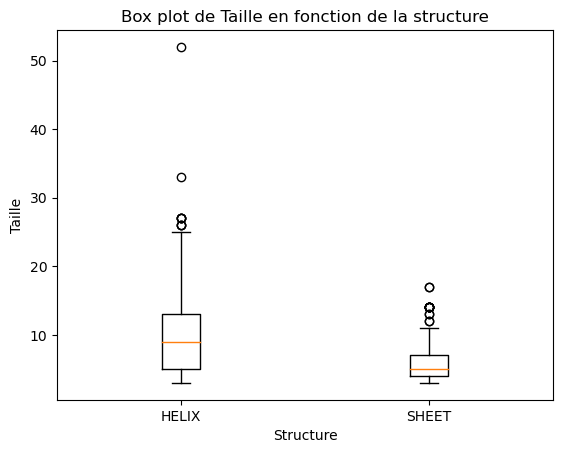

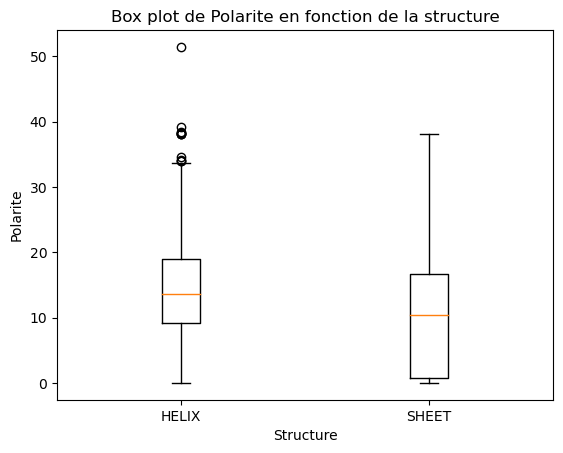

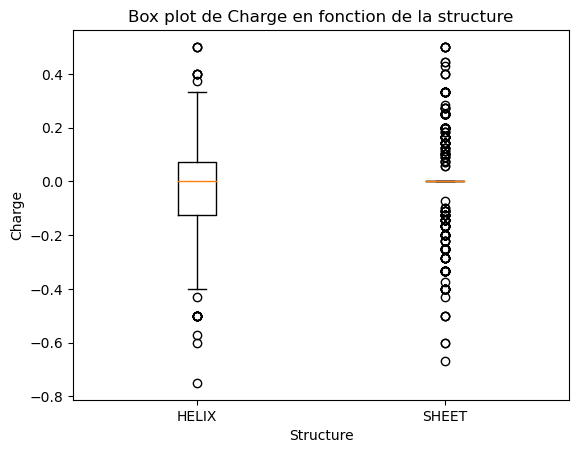

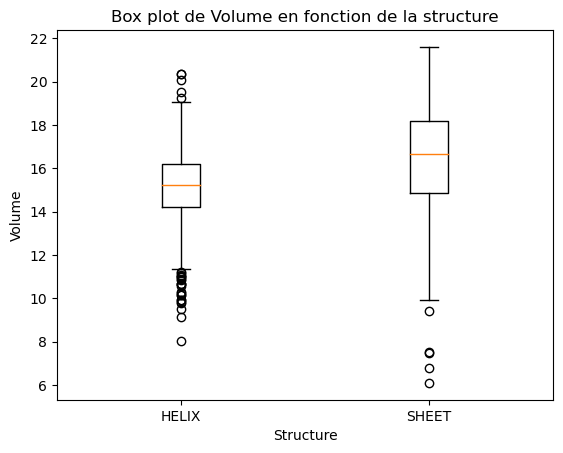

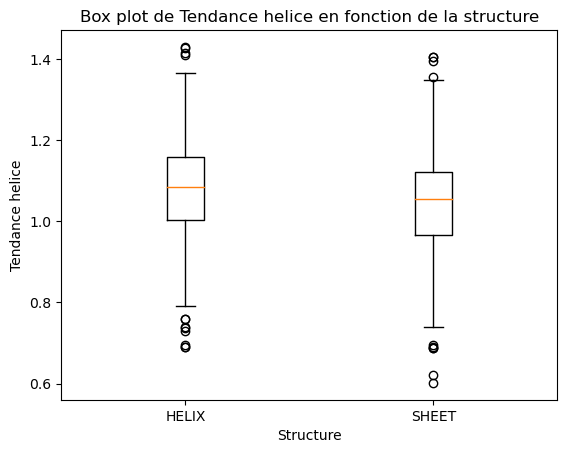

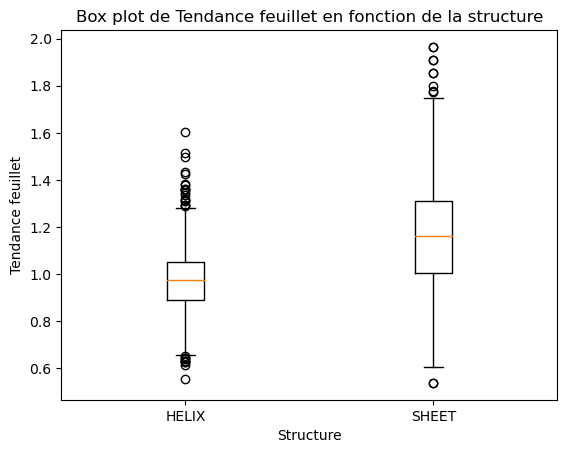

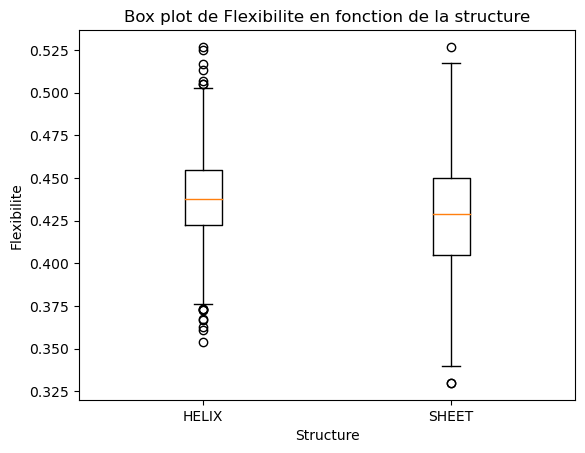

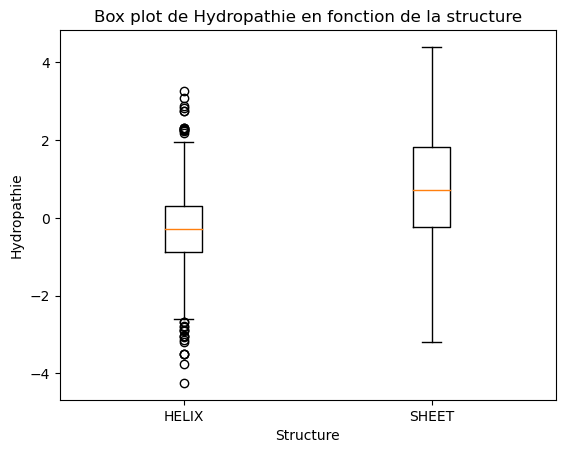

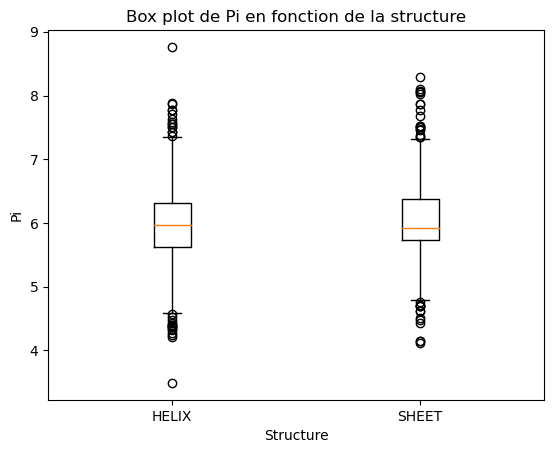

In [15]:
for nom in variables:
    fig, ax = plt.subplots()
    boxplot = ax.boxplot(x=[HELIX[nom].data, SHEET[nom].data])
    ax.set_title(f"Box plot de {nom} en fonction de la structure")
    ax.set_ylabel(f"{nom}")
    ax.set_xlabel('Structure')
    ax.set_xticklabels(['HELIX', 'SHEET'])
    plt.show()

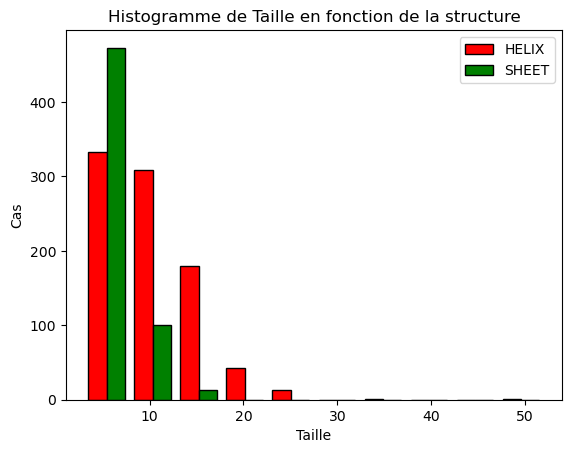

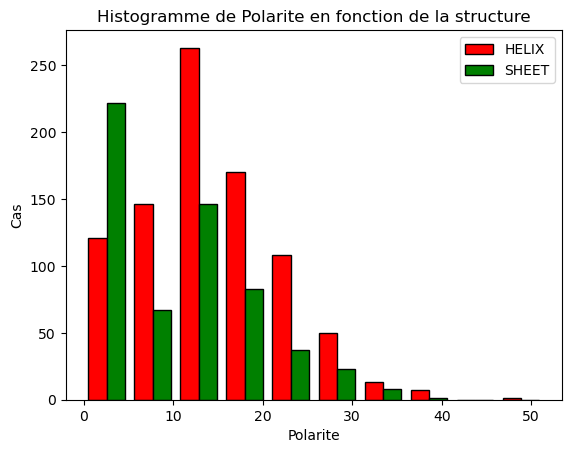

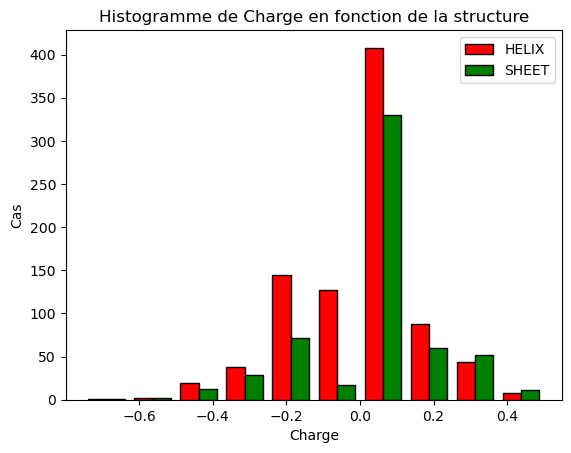

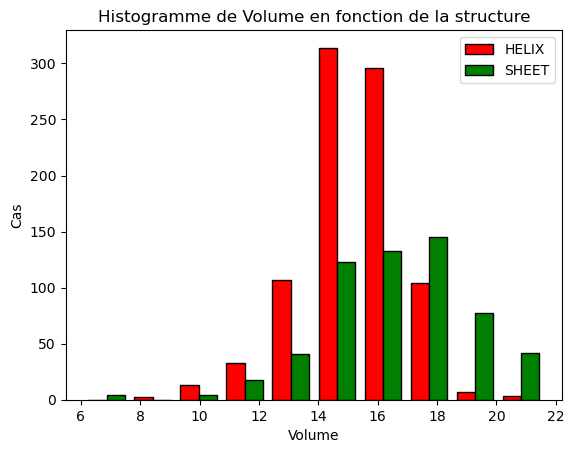

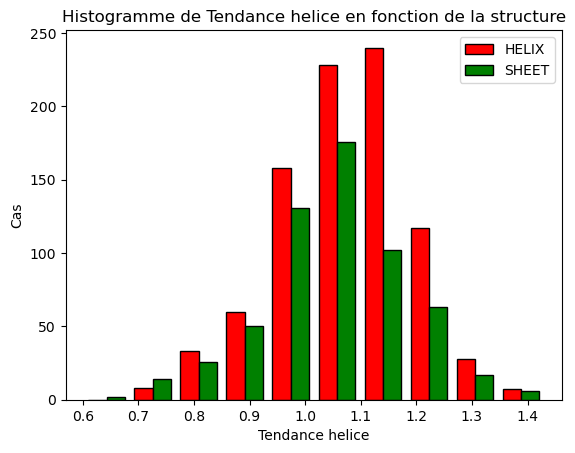

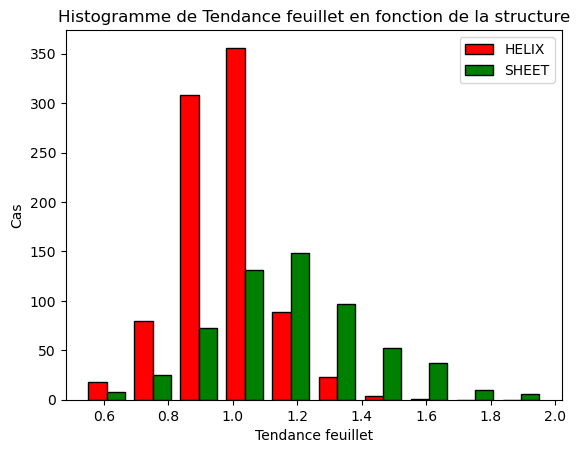

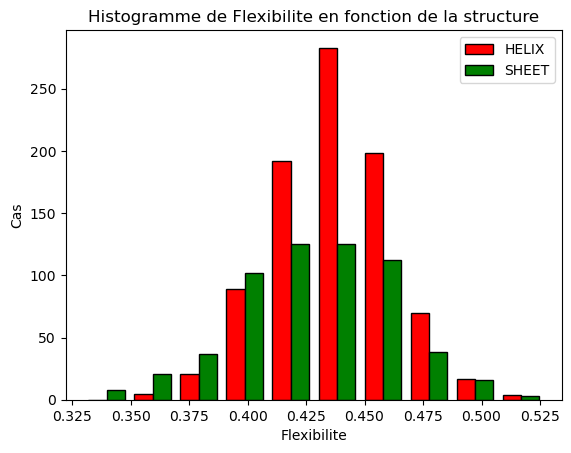

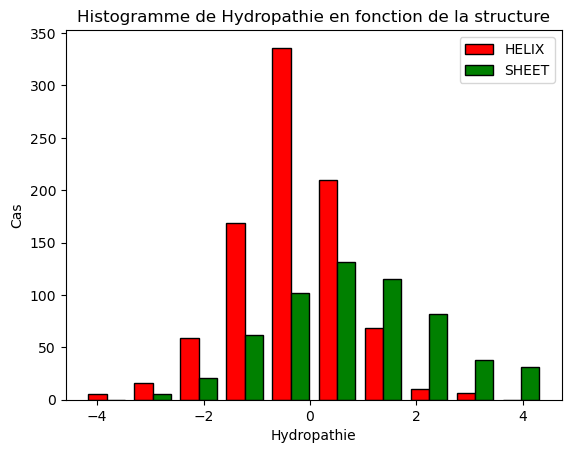

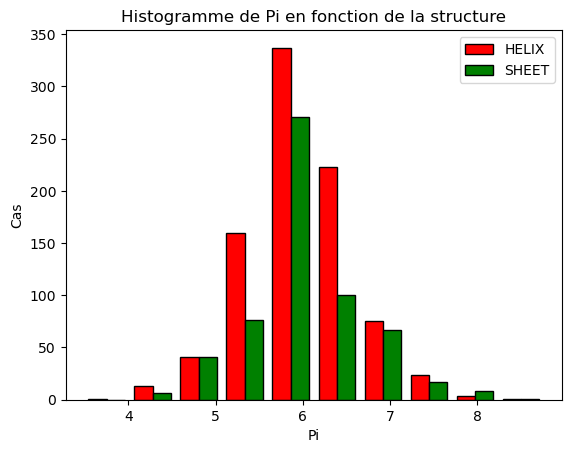

In [16]:
for nom in variables:
    plt.hist(x=[HELIX[nom].data, SHEET[nom].data], label=["HELIX", "SHEET"], color=["red", "green"], edgecolor="black")
    plt.xlabel(f'{nom}')
    plt.ylabel('Cas')
    plt.title(f'Histogramme de {nom} en fonction de la structure')
    plt.legend()
    plt.show()

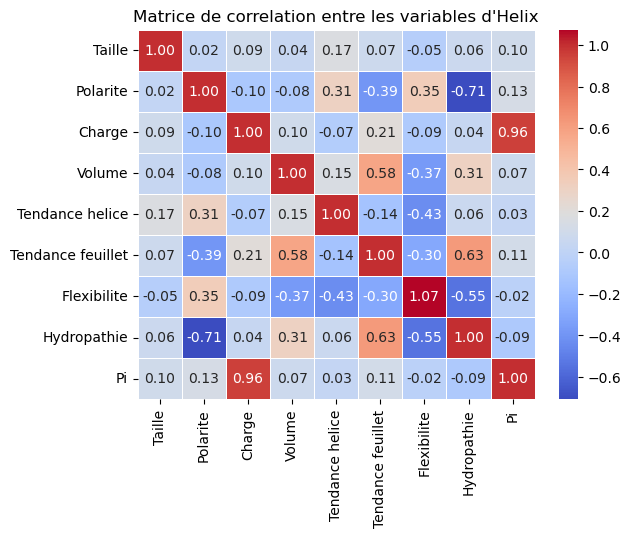

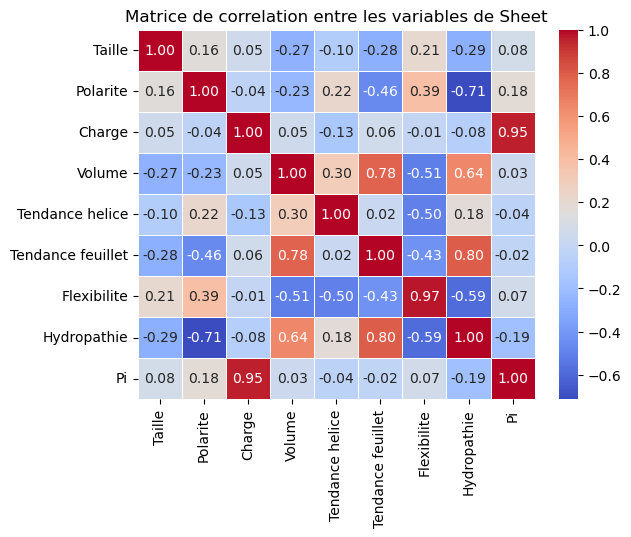

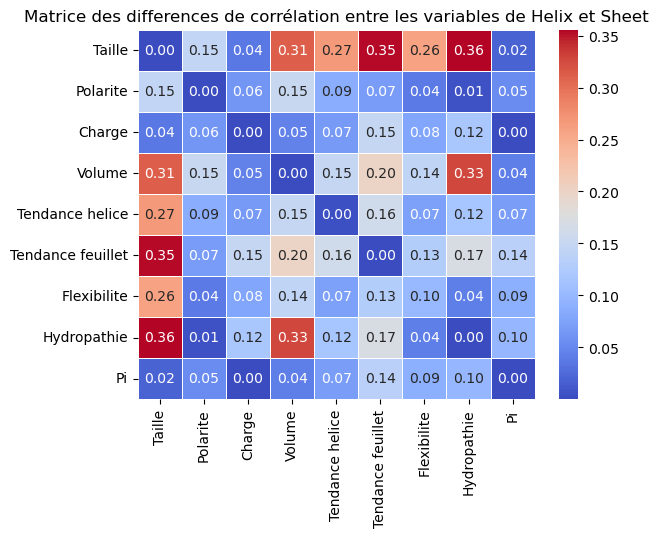

In [17]:
HELIX_matrice_correlation = np.zeros((len(HELIX), len(HELIX)))
SHEET_matrice_correlation = np.zeros((len(SHEET), len(SHEET)))

for i in range(len(variables)):
    for j in range(i, len(variables)):
        HELIX_matrice_correlation[i, j] = HELIX_matrice_correlation[j, i] = correlation_pearson(HELIX[variables[i]].data, HELIX[variables[j]].data, HELIX[variables[i]].moyenne, HELIX[variables[j]].moyenne, HELIX[variables[i]].ecart_type, HELIX[variables[j]].ecart_type)
        
for i in range(len(variables)):
    for j in range(i, len(variables)):
        SHEET_matrice_correlation[i, j] = SHEET_matrice_correlation[j, i] = correlation_pearson(SHEET[variables[i]].data, SHEET[variables[j]].data, SHEET[variables[i]].moyenne, SHEET[variables[j]].moyenne, SHEET[variables[i]].ecart_type, SHEET[variables[j]].ecart_type)

HELIX_heatmap = sns.heatmap(HELIX_matrice_correlation, cmap='coolwarm', annot=True, fmt=".2f", linewidths=.5)
HELIX_heatmap.set_xticklabels(variables, rotation=90)
HELIX_heatmap.set_yticklabels(variables, rotation=0)
plt.title("Matrice de correlation entre les variables d'Helix")
plt.show()

SHEET_heatmap = sns.heatmap(SHEET_matrice_correlation, cmap='coolwarm', annot=True, fmt=".2f", linewidths=.5)
SHEET_heatmap.set_xticklabels(variables, rotation=90)
SHEET_heatmap.set_yticklabels(variables, rotation=0)
plt.title("Matrice de correlation entre les variables de Sheet")
plt.show()

difference_matrice = np.zeros(HELIX_matrice_correlation.shape)

for i in range(len(variables)):
    for j in range(len(variables)):
        if HELIX_matrice_correlation[i, j] < 0 and SHEET_matrice_correlation[i, j] >= 0:
            difference_matrice[i, j] = abs(SHEET_matrice_correlation[i, j] - HELIX_matrice_correlation[i, j])
        else:
            difference_matrice[i, j] = abs(HELIX_matrice_correlation[i, j] - SHEET_matrice_correlation[i, j])

difference_heatmap = sns.heatmap(difference_matrice, cmap='coolwarm', annot=True, fmt=".2f", linewidths=.5)
difference_heatmap.set_xticklabels(variables, rotation=90)
difference_heatmap.set_yticklabels(variables, rotation=0)
plt.title("Matrice des differences de corrélation entre les variables de Helix et Sheet")
plt.show()

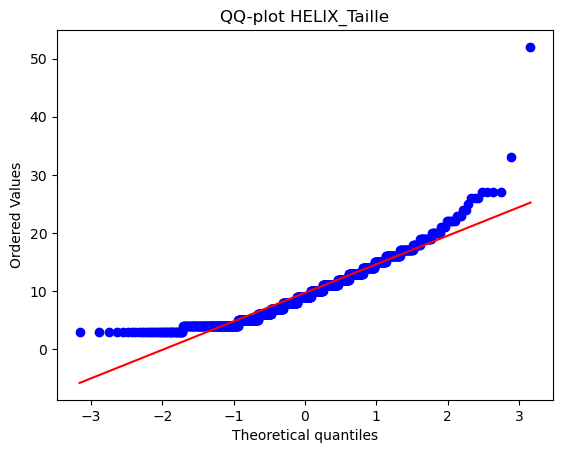

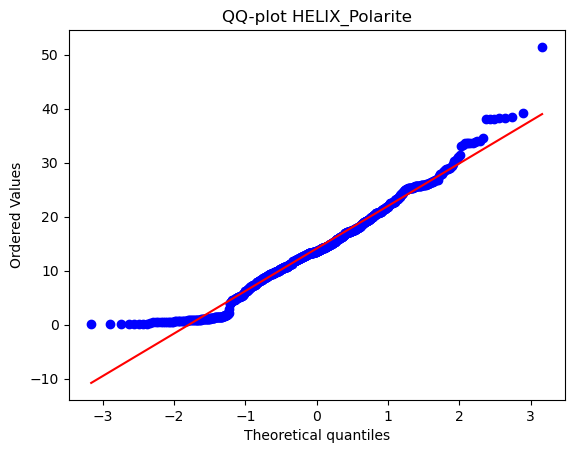

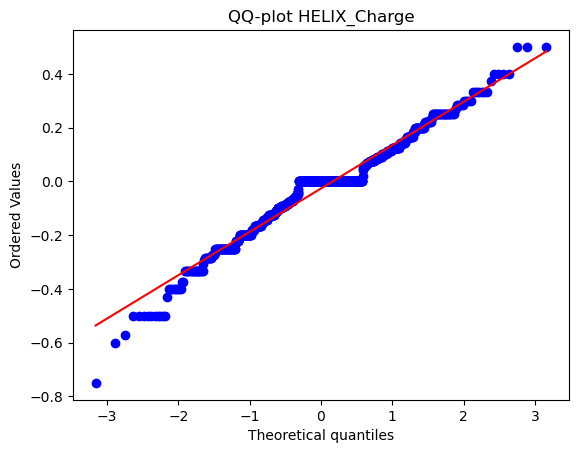

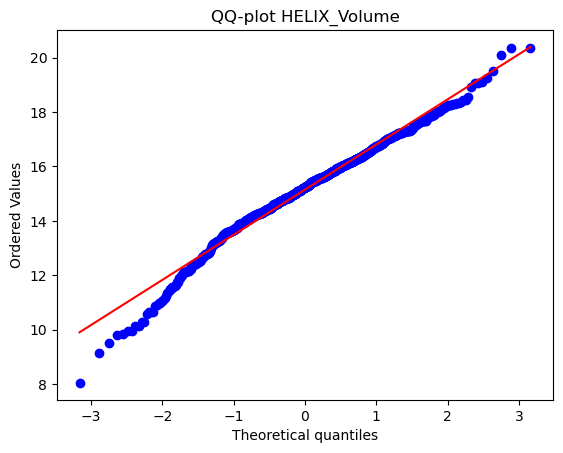

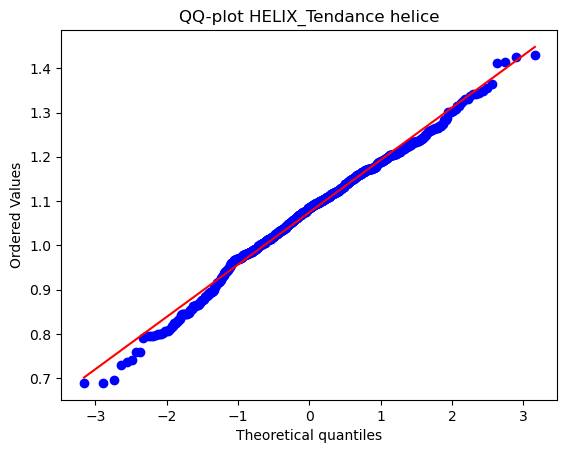

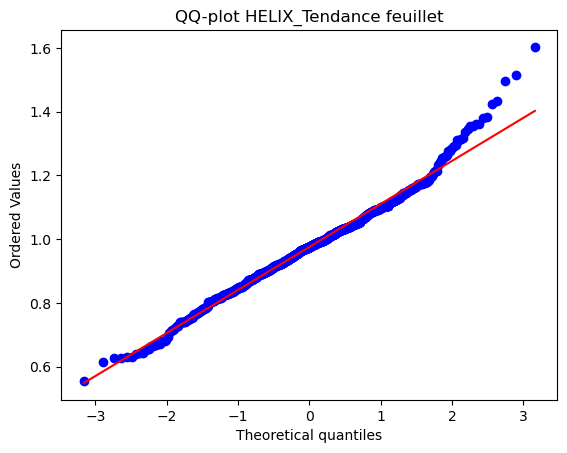

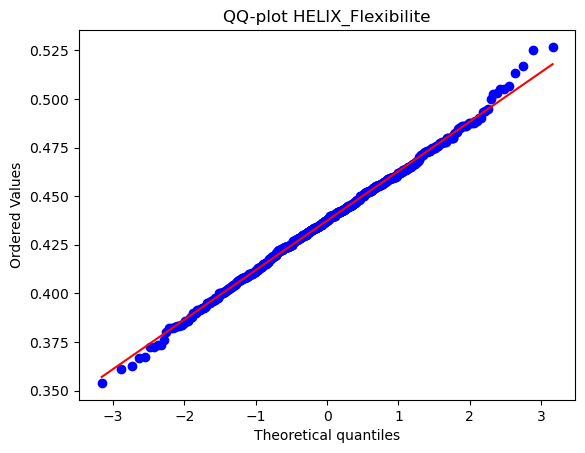

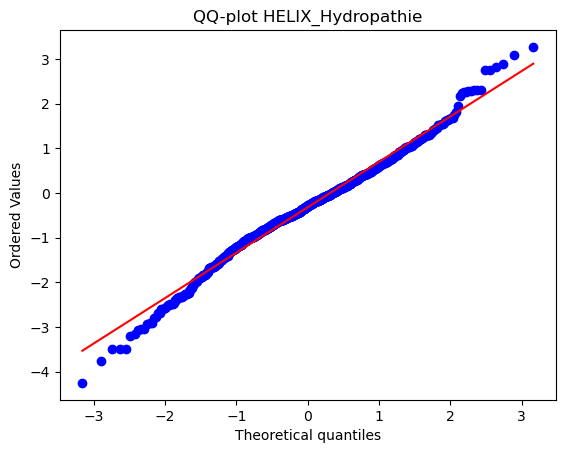

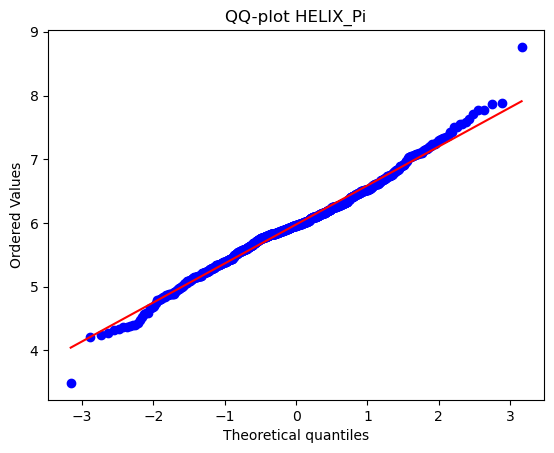

In [18]:
for var in variables:
    scipy.stats.probplot(HELIX[var].data, dist='norm', plot=plt)
    plt.title(f"QQ-plot {HELIX[var].nom}")
    plt.show()

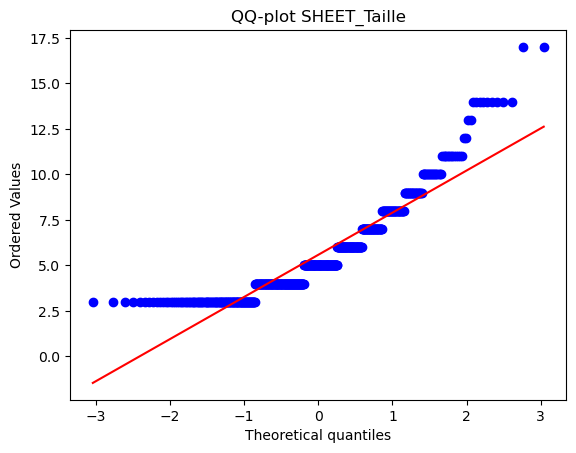

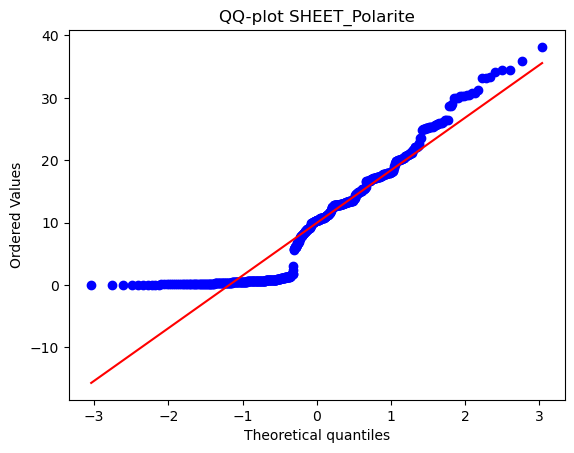

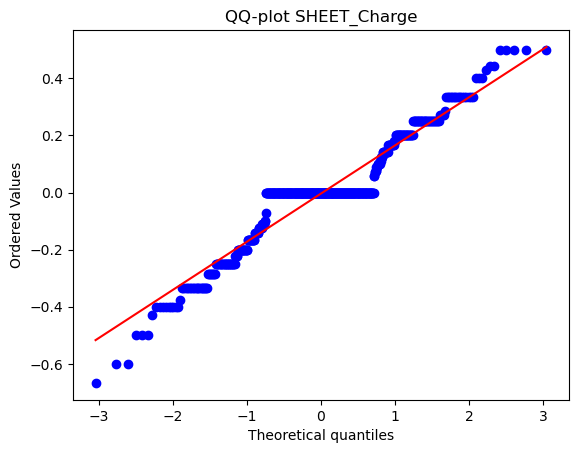

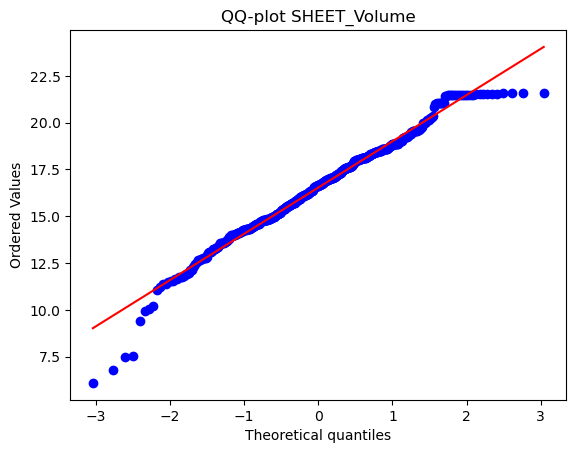

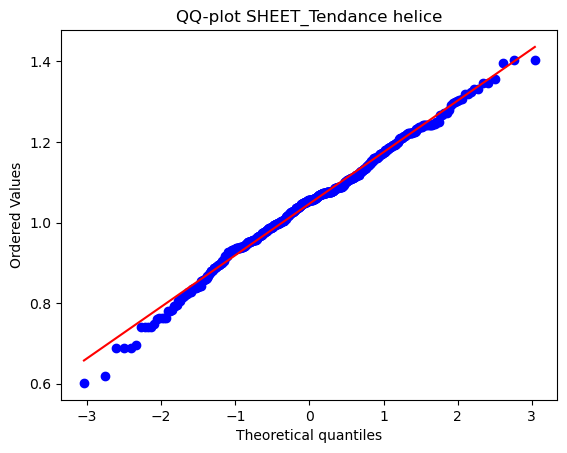

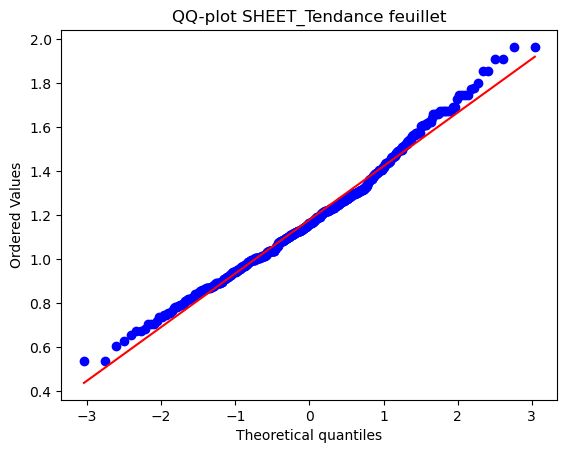

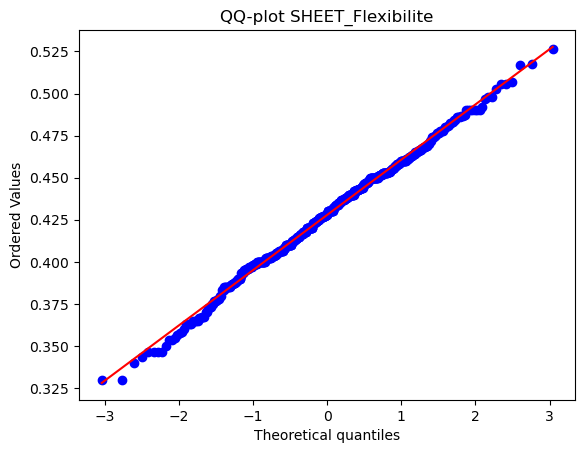

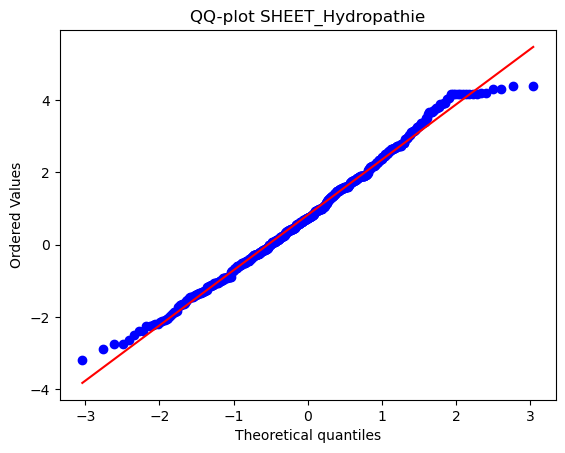

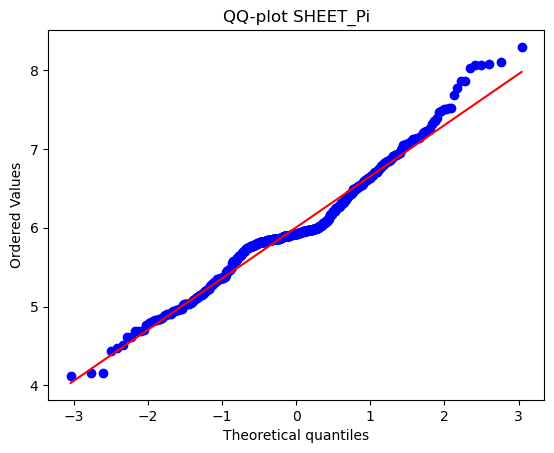

In [19]:
for var in variables:
    scipy.stats.probplot(SHEET[var].data, dist='norm', plot=plt)
    plt.title(f"QQ-plot {SHEET[var].nom}")
    plt.show()

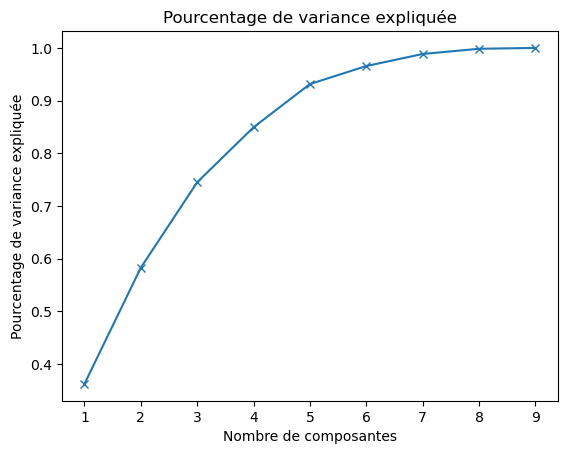

,Taille,Polarite,Charge,Volume,Tendance helice,Tendance feuillet,Flexibilite,Hydropathie,Pi
0,-0.170855,-0.380633,0.060687,0.422195,0.039813,0.482591,-0.384782,0.511120,-0.014703
1,-0.071385,-0.055511,-0.695215,-0.054154,0.062277,-0.057648,-0.022910,0.074225,-0.701663
2,-0.264225,-0.358050,0.043674,-0.187087,-0.768920,0.106617,0.395715,0.049841,-0.058279
3,0.816958,-0.441353,0.053343,-0.268889,-0.074806,-0.101772,-0.133393,0.160035,-0.057292
4,0.472414,0.349110,-0.133172,0.513274,-0.188105,0.403812,0.412757,-0.047638,-0.051736
5,0.054930,0.077579,-0.019824,0.310795,-0.506400,-0.183215,-0.633281,-0.444627,-0.072322
6,0.042297,0.488525,-0.087067,-0.574465,-0.198888,0.495727,-0.324383,0.167691,0.057601
7,-0.022253,-0.330728,0.130030,-0.146444,0.257300,0.543278,0.014090,-0.675855,-0.182857
8,0.001057,-0.230458,-0.682367,-0.004080,0.010860,0.067308,-0.014063,-0.142436,0.675361


In [20]:
df_acp = df[variables]

scaler = StandardScaler()
donnees_standardisees = scaler.fit_transform(df_acp)

pca = PCA()

resultats_acp = pca.fit_transform(donnees_standardisees)

plt.plot(range(1, len(variables) + 1), pca.explained_variance_ratio_.cumsum(), marker='x')
plt.xlabel('Nombre de composantes')
plt.ylabel('Pourcentage de variance expliquée')
plt.title('Pourcentage de variance expliquée')
plt.show()

composantes_principales = pca.components_
df_contributions = pd.DataFrame(composantes_principales, columns=df_acp.columns)
df_contributions

In [21]:
HELIX_positions = {}
SHEET_positions = {}

for seq in df.loc[(df["Structure"] == "HELIX") & (df["Taille"] == 10), ["Sequence"]]["Sequence"]:
    for pos, acide_amine in enumerate(seq):
        if pos+1 in HELIX_positions.keys():
            HELIX_positions[pos+1].append(acide_amine)
        else:
            HELIX_positions[pos+1] = [acide_amine]

for seq in df.loc[(df["Structure"] == "SHEET") & (df["Taille"] == 10), ["Sequence"]]["Sequence"]:
    for pos, acide_amine in enumerate(seq):
        if pos+1 in SHEET_positions.keys():
            SHEET_positions[pos+1].append(acide_amine)
        else:
            SHEET_positions[pos+1] = [acide_amine]

HELIX_positions_valeurs = {}
SHEET_positions_valeurs = {}
colonnes = dict(list(AA.values())[0]).keys()

for pos in HELIX_positions.keys():
    HELIX_positions_valeurs[pos] = {}
    for col in colonnes:
        HELIX_positions_valeurs[pos][col] = 0

for pos, seq in HELIX_positions.items():
    for acide_amine in seq:
        for col in colonnes:
            HELIX_positions_valeurs[pos][col] += AA[acide_amine][col]

for pos in HELIX_positions.keys():
    for col in colonnes:
        HELIX_positions_valeurs[pos][col] /= len(HELIX_positions[pos])

for pos in SHEET_positions.keys():
    SHEET_positions_valeurs[pos] = {}
    for col in colonnes:
        SHEET_positions_valeurs[pos][col] = 0
        
for pos, seq in SHEET_positions.items():
    for acide_amine in seq:
        for col in colonnes:
            SHEET_positions_valeurs[pos][col] += AA[acide_amine][col]

for pos in SHEET_positions.keys():
    for col in colonnes:
        SHEET_positions_valeurs[pos][col] /= len(SHEET_positions[pos])

In [22]:
df_helix_positions = pd.DataFrame(HELIX_positions_valeurs).transpose()
df_helix_positions

,Polarite,Charge,Volume,Tendance helice,Tendance feuillet,Flexibilite,Hydropathie,Pi
1,15.502542,-0.101695,13.892373,0.893356,0.864373,0.465254,-1.259322,5.709492
2,12.610847,0.016949,15.382542,1.059017,1.036864,0.436610,0.023729,6.074068
3,23.582712,-0.118644,14.359153,1.006983,0.800424,0.465085,-1.635593,5.741525
4,11.621356,-0.152542,15.150339,1.108305,0.987373,0.428814,0.293220,5.431017
5,13.380847,0.033898,16.287627,1.204373,1.087102,0.417288,0.561017,6.176102
6,16.165763,-0.067797,14.638136,1.090831,0.944068,0.444068,-0.857627,5.772034
7,11.727797,0.050847,15.238305,1.124847,0.975119,0.430847,-0.101695,6.126271
8,14.958983,0.050847,15.016610,1.169373,1.003271,0.436271,0.013559,6.262034
9,14.476102,0.237288,16.500678,1.118034,1.102356,0.435424,-0.100000,6.865424
10,13.698305,0.033898,14.278814,1.055627,0.934136,0.444237,-0.705085,6.054915


In [23]:
df_sheet_positions = pd.DataFrame(SHEET_positions_valeurs).transpose()
df_sheet_positions

,Polarite,Charge,Volume,Tendance helice,Tendance feuillet,Flexibilite,Hydropathie,Pi
1,16.088421,0.105263,14.854211,1.135684,1.017474,0.440000,0.200000,6.484211
2,11.464211,0.000000,15.422632,0.952737,0.918632,0.454211,-0.626316,5.947368
3,11.322632,0.105263,17.014737,1.063053,1.186000,0.415789,0.336842,6.261579
4,8.491053,-0.157895,13.751053,0.983947,0.873211,0.437895,0.110526,5.377895
5,5.743158,0.105263,15.787895,1.103000,1.203368,0.400526,1.468421,6.114737
6,8.308947,0.105263,16.666316,0.980316,1.366632,0.453158,1.894737,6.396316
7,21.765263,0.000000,15.598421,1.152526,1.054789,0.464211,-0.500000,6.336316
8,24.021053,-0.157895,15.527895,1.090053,1.058684,0.470526,-0.415789,5.662105
9,5.766316,-0.052632,12.981053,1.038526,1.039211,0.430526,0.784211,5.653684
10,19.060000,-0.052632,16.085789,1.129368,1.122474,0.438421,-0.052632,5.852105


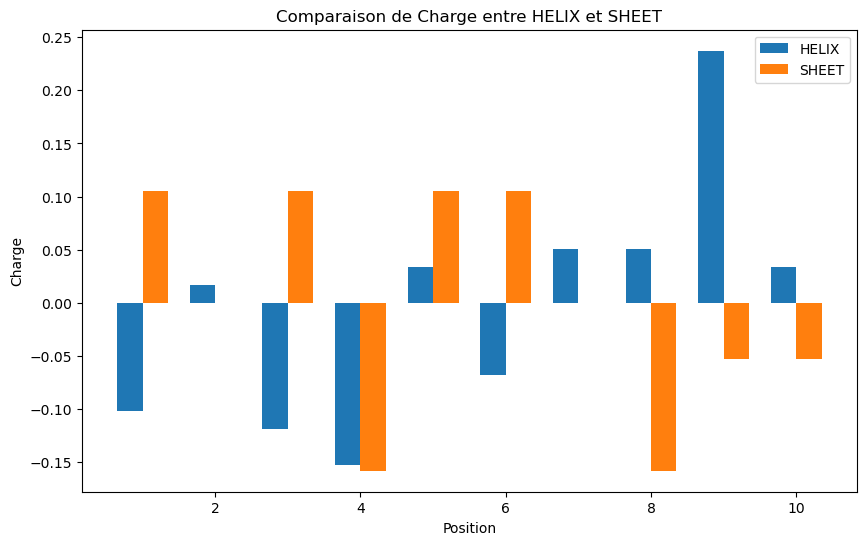

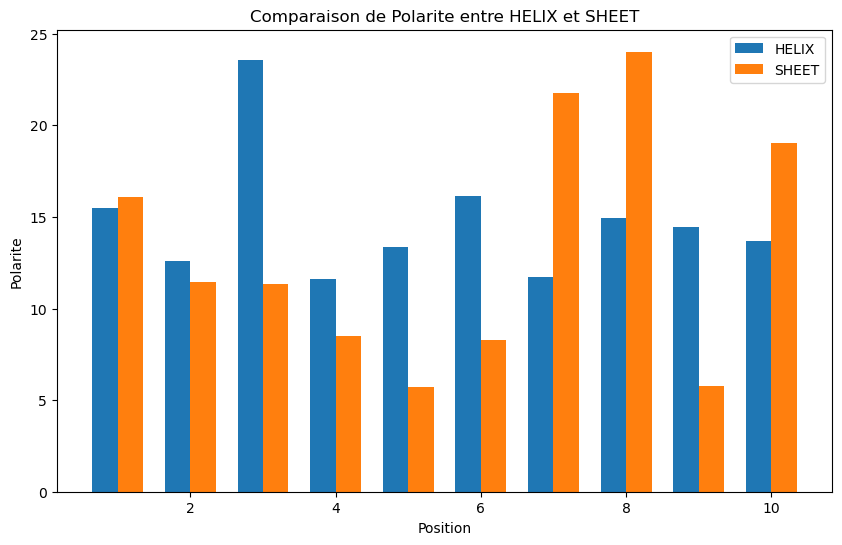

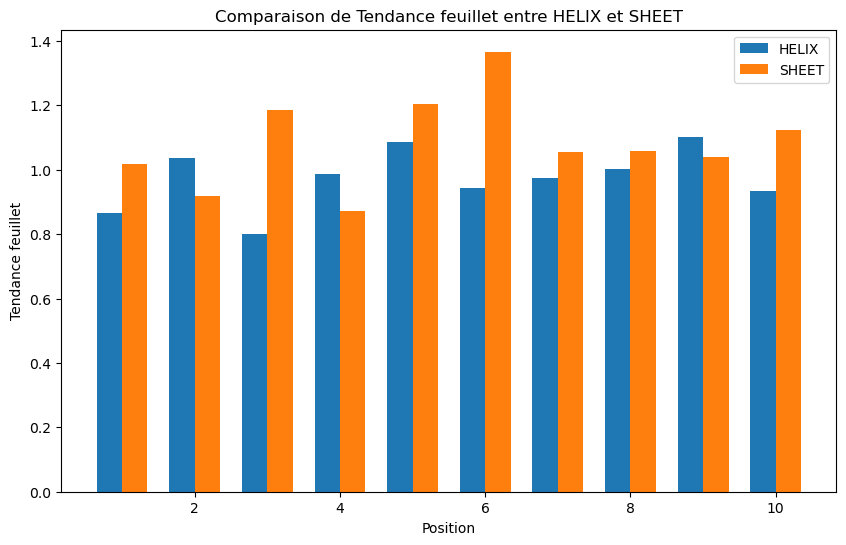

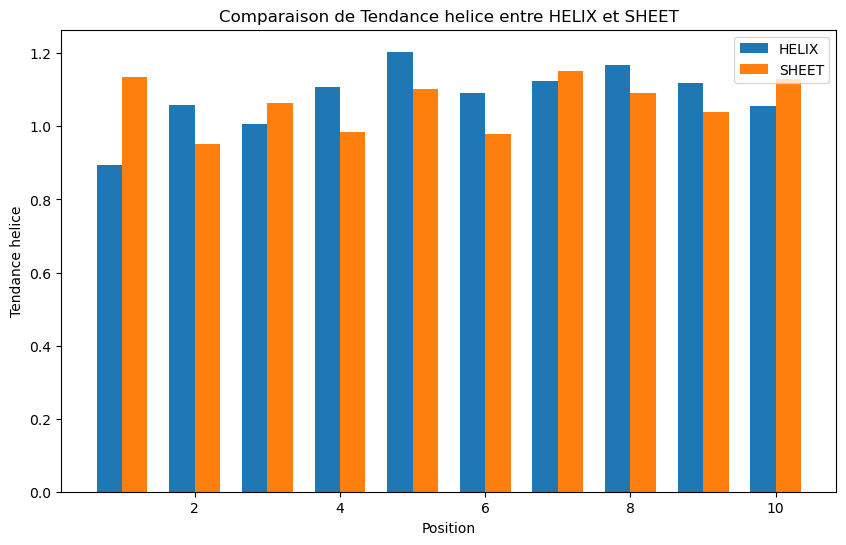

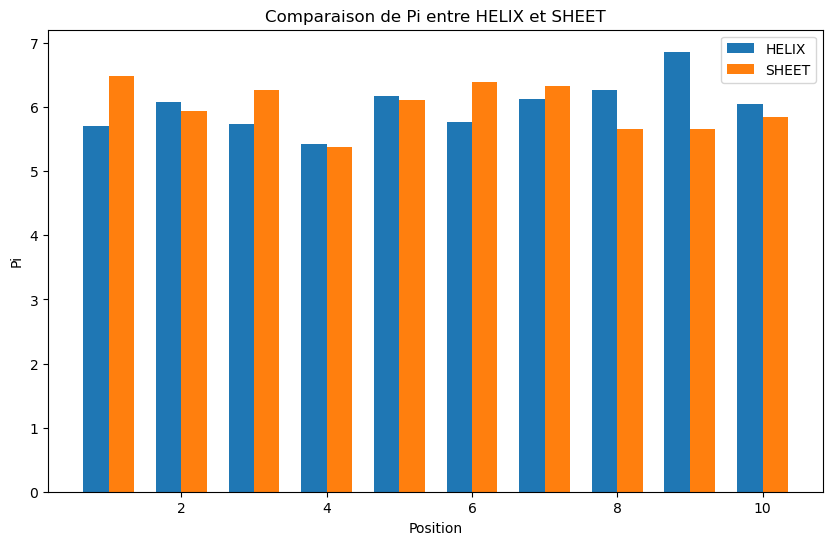

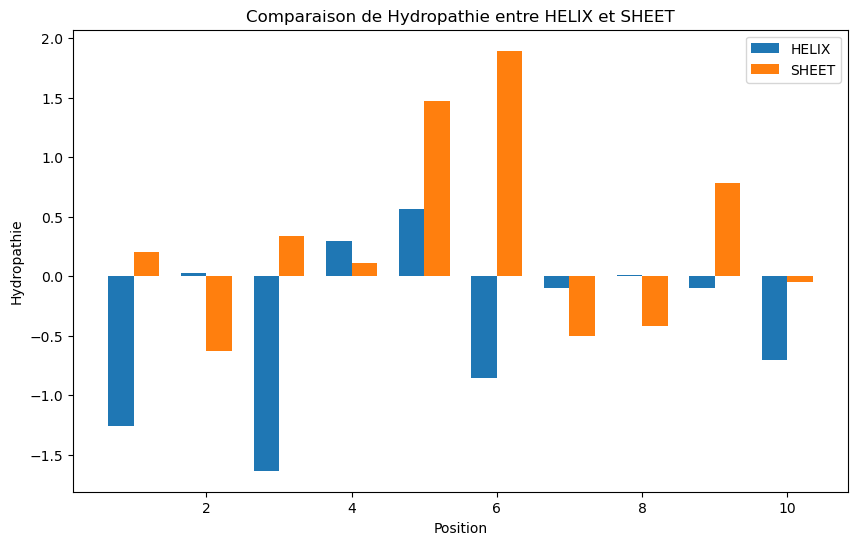

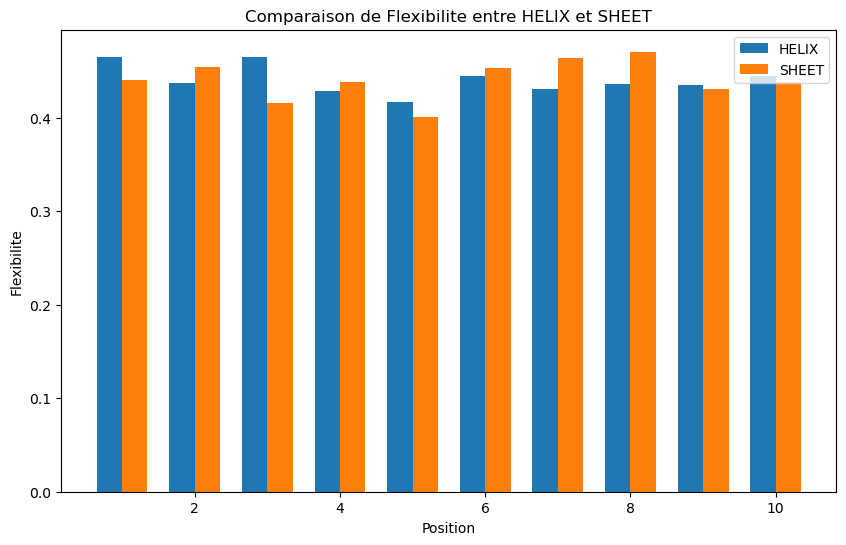

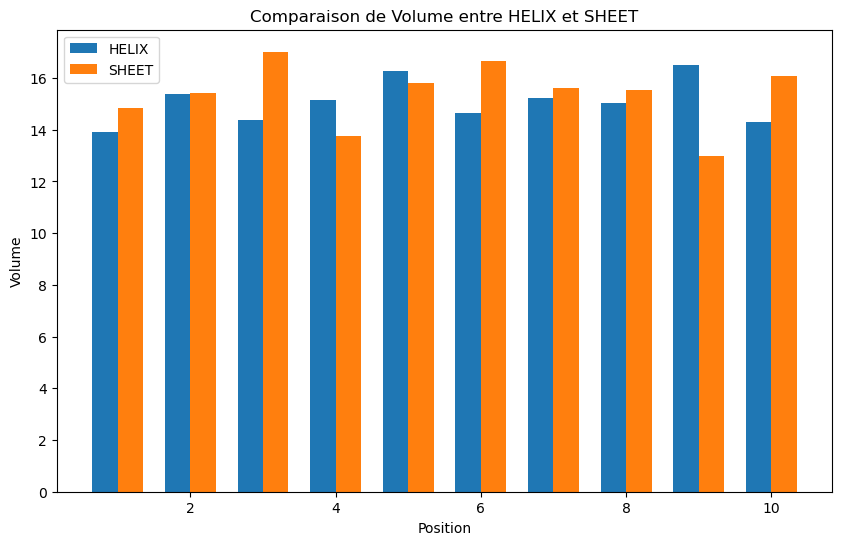

In [24]:
bar_width = 0.35
positions = np.arange(1, max(len(df_helix_positions), len(df_sheet_positions))+1)

for col in set(df_helix_positions.columns) & set(df_sheet_positions.columns):
    plt.figure(figsize=(10, 6))
    
    if col in df_helix_positions.columns:
        plot_length = min(len(df_helix_positions[col]), len(df_sheet_positions[col]))
        
        plt.bar(positions[:plot_length] - bar_width/2, df_helix_positions[col][:plot_length], bar_width, label='HELIX')
    if col in df_sheet_positions.columns:
        plot_length = min(len(df_helix_positions[col]), len(df_sheet_positions[col]))
        
        plt.bar(positions[:plot_length] + bar_width/2, df_sheet_positions[col][:plot_length], bar_width, label='SHEET')
    
    plt.title(f'Comparaison de {col} entre HELIX et SHEET')
    plt.xlabel('Position')
    plt.ylabel(col)
    plt.legend()
    plt.show()

In [13]:
variables = table_erreur.iloc[0]['Dimension'][1:-1].replace("'", "").split(', ')
voisins = table_erreur.iloc[0]['Voisin']

In [26]:
HELIX_cr = df.loc[df["Structure"] == "HELIX", list(variables+['Structure'])].copy()
SHEET_cr = df.loc[df["Structure"] == "SHEET", list(variables+['Structure'])].copy()

HELIX_cr[variables] = (HELIX_cr[variables] - HELIX_cr[variables].mean()) / HELIX_cr[variables].std()
SHEET_cr[variables] = (SHEET_cr[variables] - SHEET_cr[variables].mean()) / SHEET_cr[variables].std()

In [27]:
for k in range(1, 10):
    centroides = []
    clusters = []

    points = []
    centroides_initial = [[] for _ in range(k)]

    for i in range(k):
        for var in variables:
            mini = min((HELIX_cr[var].min(), SHEET_cr[var].min()))
            maxi = max((HELIX_cr[var].max(), SHEET_cr[var].max()))
            centroides_initial[i].append(random.uniform(mini, maxi))

    for _, tup in HELIX_cr.iterrows():
        point = []
        for var in variables:
            point.append(tup[var])
        point.append("HELIX")
        points.append(point)

    for _, tup in SHEET_cr.iterrows():
        point = []
        for var in variables:
            point.append(tup[var])
        point.append("SHEET")
        points.append(point)

    centroides, clusters = calcul_k_means(points, centroides_initial, len(variables))

    compte = proportion_clusters(clusters, ["HELIX", "SHEET"])

    print(qualite_clusters(centroides, clusters), compte)

0.0 {1: {'HELIX': 879, 'SHEET': 587}}
1.7768969607870142 {1: {'HELIX': 414, 'SHEET': 265}, 2: {'HELIX': 465, 'SHEET': 322}}
1.7768969607870142 {1: {'HELIX': 414, 'SHEET': 265}, 2: {'HELIX': 465, 'SHEET': 322}}
1.6146194868065162 {1: {'HELIX': 312, 'SHEET': 233}, 2: {'HELIX': 318, 'SHEET': 209}, 3: {'HELIX': 249, 'SHEET': 145}}
1.4438960446447644 {1: {'HELIX': 227, 'SHEET': 119}, 2: {'HELIX': 205, 'SHEET': 129}, 3: {'HELIX': 188, 'SHEET': 141}, 4: {'HELIX': 259, 'SHEET': 198}}
1.3984809357757177 {1: {'HELIX': 202, 'SHEET': 115}, 2: {'HELIX': 216, 'SHEET': 167}, 3: {'HELIX': 124, 'SHEET': 81}, 4: {'HELIX': 154, 'SHEET': 94}, 5: {'HELIX': 183, 'SHEET': 130}}
1.3633568680982149 {1: {'HELIX': 176, 'SHEET': 73}, 2: {'HELIX': 81, 'SHEET': 93}, 3: {'HELIX': 98, 'SHEET': 85}, 4: {'HELIX': 119, 'SHEET': 74}, 5: {'HELIX': 98, 'SHEET': 69}, 6: {'HELIX': 157, 'SHEET': 99}, 7: {'HELIX': 150, 'SHEET': 94}}
1.3819519059492933 {1: {'HELIX': 138, 'SHEET': 106}, 2: {'HELIX': 161, 'SHEET': 98}, 3: {'HELIX

In [28]:
HS_cr = pd.concat([HELIX_cr, SHEET_cr])
HS_cr

,Taille,Charge,Tendance helice,Tendance feuillet,Hydropathie,Structure
0,-0.532560,0.160252,-1.379889,1.724264,1.952433,HELIX
1,0.635793,0.629326,0.173227,0.569654,0.622466,HELIX
2,-1.116736,1.685201,-0.409508,-0.921165,-2.776404,HELIX
3,-1.311461,0.160252,-0.312386,2.226365,0.836183,HELIX
4,0.441067,-0.347860,-0.241444,-0.162484,-0.283500,HELIX
...,...,...,...,...,...,...
1675,-1.036714,0.018966,0.140295,-1.058585,0.376492,SHEET
1684,-0.634765,1.430188,1.392382,-0.229485,0.474543,SHEET
1685,-1.036714,-1.862476,-0.615018,1.274178,0.528994,SHEET
1686,-1.036714,0.018966,-0.183076,2.316685,1.095530,SHEET


In [29]:
matrice_distance = np.zeros((HS_cr.shape[0], HS_cr.shape[0]))

In [30]:
identifiant = list(HS_cr["Structure"])

In [31]:
for i in range(HS_cr.shape[0]):
    for j in range(i, HS_cr.shape[0]):
        distance = distance_minkowski(HS_cr.iloc[i, :-1], HS_cr.iloc[j, :-1], len(HS_cr.iloc[i, :-1]), 2)
        matrice_distance[i, j] = distance
        matrice_distance[j, i] = distance

In [32]:
texte = calcul_cah(matrice_distance, identifiant)

with open("CAH_structure_cr.txt", "w") as filout:
    filout.write(texte)

In [55]:
identifiant = list(HS_cr["Structure"])
Z = scipy.cluster.hierarchy.linkage(matrice_distance, method='complete', metric='euclidean', optimal_ordering=True)

plt.figure(figsize=(150, 90))
scipy.cluster.hierarchy.dendrogram(Z, orientation='top', labels=identifiant, distance_sort='descending')
plt.xticks(rotation='vertical')
plt.title('CAH des structures')
plt.xlabel('Type de structure')
plt.ylabel('Distance euclidienne')
plt.savefig('CAH_structure_cr.svg', format='svg', bbox_inches='tight')
plt.show()

C:\Users\33699\AppData\Local\Temp\ipykernel_8604\2740445523.py:2: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(matrice_distance, method='complete', metric='euclidean', optimal_ordering=True)


In [17]:
identifiant_AA = list(AA.keys())
matrice_distance_AA = np.zeros((len(identifiant_AA), len(identifiant_AA)))

In [18]:
for i, AA1 in enumerate(identifiant_AA):
    for j, AA2 in enumerate(identifiant_AA):
        if i < j:
            AA1_coord, AA2_coord = [], []
            for var in variables:
                if var != 'Taille':
                    AA1_coord.append(AA[AA1][var])
                    AA2_coord.append(AA[AA2][var])
            distance = distance_minkowski(AA1_coord, AA2_coord, len(AA1_coord), 2)
            matrice_distance_AA[i, j] = distance
            matrice_distance_AA[j, i] = distance

In [19]:
AA_indice = {val: ind for ind, val in enumerate(identifiant_AA)}

In [20]:
points_supervise = []
for _, tup in df[variables+['Sequence', 'Structure']].iterrows():
    points_supervise.append(tup.values)

In [27]:
erreur_knn = 0
erreur_k_homologie = 0
for _, tup in test[variables+['Sequence', 'Structure']].iterrows():
    compte_distance = {"HELIX": 0, "SHEET": 0}
    compte = {"HELIX": 0, "SHEET": 0}
    homologie = []
    prediction_knn, vois = knn(tup[variables].values, voisins, points_supervise)
    determine = vois[0]
    for v in vois:
        compte[v[-1]] += 1
        homologie.append((abs(alignement_distance(tup["Sequence"], v[-2], 0, matrice_distance_AA, AA_indice, -0.5)), v[-1]))
    moy = {'HELIX': 0, 'SHEET': 0}
    for v in homologie:
        moy[v[-1]] += v[0]
    for stru, val in moy.items():
        moy[stru] /= compte[stru]
    prediction_k_homologie = min(moy, key=lambda k: moy[k])
    if prediction_knn != tup["Structure"]:
        erreur_knn += 1
    if prediction_k_homologie != tup["Structure"]:
        erreur_k_homologie += 1
print(erreur_knn, erreur_k_homologie, len(test))

55 192 304


In [9]:
variables = ["Polarite", "Charge", "Volume", "Tendance helice", "Tendance feuillet", "Flexibilite", "Hydropathie", "Pi"]
df_AA = pd.DataFrame(AA).transpose()
df_AA

,Polarite,Charge,Volume,Tendance helice,Tendance feuillet,Flexibilite,Hydropathie,Pi
A,0.00,0.0,11.50,1.489,0.709,0.36,1.8,6.00
R,52.00,1.0,14.28,1.224,0.920,0.53,-4.5,10.76
N,3.38,0.0,12.82,0.772,0.604,0.46,-3.5,5.41
D,49.70,-1.0,11.68,0.924,0.541,0.51,-3.5,2.77
C,1.48,0.0,13.46,0.966,1.191,0.35,2.5,5.05
Q,3.53,0.0,14.45,1.164,0.840,0.49,-3.5,5.65
E,49.90,-1.0,13.57,1.504,0.567,0.50,-3.5,3.22
G,0.00,0.0,3.40,0.510,0.657,0.54,-0.4,5.97
H,51.60,0.0,13.69,1.003,0.863,0.32,-3.2,7.59
I,0.13,0.0,21.40,1.003,1.799,0.46,4.5,6.02


In [10]:
quali_AA = {acide_amine: dict() for acide_amine in df_AA.index}

In [11]:
for acide_amine, tup in df_AA.iterrows():
    for var in variables:
        if var != "Charge":
            if tup[var] <= np.percentile(df_AA[var], 20):
                quali_AA[acide_amine][var] = "--"
            elif tup[var] <= np.percentile(df_AA[var], 40):
                quali_AA[acide_amine][var] = "-"
            elif tup[var] <= np.percentile(df_AA[var], 60):
                quali_AA[acide_amine][var] = "0"
            elif tup[var] <= np.percentile(df_AA[var], 80):
                quali_AA[acide_amine][var] = "+"
            else:
                quali_AA[acide_amine][var] = "++"
        else:
            if tup[var] > 0:
                quali_AA[acide_amine][var] = "+"
            else:
                quali_AA[acide_amine][var] = "-" if tup[var] < 0 else "0"

In [12]:
df_quali_AA = pd.DataFrame(quali_AA).transpose()
df_quali_AA

,Polarite,Charge,Volume,Tendance helice,Tendance feuillet,Flexibilite,Hydropathie,Pi
A,--,0,--,++,-,-,+,+
R,++,+,0,+,0,++,--,++
N,+,0,-,--,--,0,--,-
D,++,-,--,-,--,+,--,--
C,-,0,-,-,0,-,+,--
Q,+,0,0,+,-,+,--,-
E,++,-,-,++,--,+,--,--
G,--,0,--,--,-,++,+,+
H,++,0,-,0,0,--,-,++
I,--,0,++,0,++,0,++,+


In [13]:
en_compte = 4

with open("structure_secondaire_quali.txt", "w") as filout:
    texte = ""
    for i in range(en_compte, 0, -1):
        for var in variables:
            texte += f"{var}(n-{i});"
        texte += f"Structure(n-{i});AA(n-{i});"
    for var in variables:
        texte += f"{var}(n);"
    texte += "AA(n);"
    for i in range(1, en_compte+1):
        for var in variables:
            texte += f"{var}(n+{i});"
        texte += f"AA(n+{i});"
    texte += "Structure(n)\n"
    for fic in os.listdir("Sequence"):
        pid = fic[:-4]
        with open(f"Sequence/{pid}.txt", "r") as filseq:
            filseq.readline()
            seq = filseq.readline()
            structure = ["Vide" for _ in range(len(seq))]
            with open(f"Structure secondaire/{pid}.txt", "r") as filstr:
                for ligne in filstr:
                    ligne = ligne[:-1].split(';')
                    if ligne[0] == "HELIX" and len(ligne) == 11 and ligne[4] == "A":
                        debut, fin = int(ligne[5]), int(ligne[8])
                        if debut < fin and debut < len(seq) and fin < len(seq):
                            for i in range(debut-1, fin):
                                structure[i] = "Structure"
                    elif ligne[0] == "SHEET" and len(ligne) == 19 and ligne[5] == "A":
                        debut, fin = int(ligne[6]), int(ligne[9])
                        if debut < fin and debut < len(seq) and fin < len(seq):
                            for i in range(debut-1, fin):
                                structure[i] = "Structure"
            ss_texte = ""
            for n in range(len(seq)):
                for i in range(en_compte, 0, -1):
                    if n-i < 0:
                        for var in variables:
                            ss_texte += "Vide;"
                        ss_texte += "Vide;Vide;"
                    else:
                        for var in variables:
                            ss_texte += quali_AA[seq[n-i]][var] + ";"
                        ss_texte += structure[n-i] + f";{seq[n-i]};"
                for var in variables:
                    ss_texte += quali_AA[seq[n]][var] + ";"
                ss_texte += f"{seq[n]};"
                for i in range(1, en_compte+1):
                    if n+i >= len(seq):
                        for var in variables:
                            ss_texte += "Vide;"
                        ss_texte += "Vide;"
                    else:
                        for var in variables:
                            ss_texte += quali_AA[seq[n+i]][var] + ";"
                        ss_texte += f"{seq[n+i]};"
                ss_texte += structure[n] + "\n"
            texte += ss_texte
    filout.write(texte)

In [14]:
supervise_structure = pd.read_csv("structure_secondaire_quali.txt", sep=";")
supervise_structure

,Polarite(n-4),Charge(n-4),Volume(n-4),Tendance helice(n-4),Tendance feuillet(n-4),Flexibilite(n-4),Hydropathie(n-4),Pi(n-4),Structure(n-4),AA(n-4),...,Polarite(n+4),Charge(n+4),Volume(n+4),Tendance helice(n+4),Tendance feuillet(n+4),Flexibilite(n+4),Hydropathie(n+4),Pi(n+4),AA(n+4),Structure(n)
0,Vide,Vide,Vide,Vide,Vide,Vide,Vide,Vide,Vide,Vide,...,++,+,0,+,0,++,--,++,R,Vide
1,Vide,Vide,Vide,Vide,Vide,Vide,Vide,Vide,Vide,Vide,...,--,0,++,0,++,-,++,--,V,Vide
2,Vide,Vide,Vide,Vide,Vide,Vide,Vide,Vide,Vide,Vide,...,+,0,0,+,-,+,--,-,Q,Structure
3,Vide,Vide,Vide,Vide,Vide,Vide,Vide,Vide,Vide,Vide,...,--,0,--,--,-,++,+,+,G,Structure
4,-,0,+,++,+,--,+,0,Vide,M,...,0,0,+,--,--,+,-,++,P,Structure
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26670,0,0,+,--,--,+,-,++,Vide,P,...,++,-,-,++,--,+,--,--,E,Vide
26671,0,0,--,--,0,+,0,0,Vide,S,...,Vide,Vide,Vide,Vide,Vide,Vide,Vide,Vide,Vide,Vide
26672,0,0,0,-,+,0,0,-,Vide,T,...,Vide,Vide,Vide,Vide,Vide,Vide,Vide,Vide,Vide,Vide
26673,++,+,0,+,0,++,--,++,Vide,R,...,Vide,Vide,Vide,Vide,Vide,Vide,Vide,Vide,Vide,Vide


In [15]:
df_apprentissage = pd.read_csv("structure_secondaire_quali.txt", sep=";", keep_default_na=False, low_memory=False).sample(n=250).reset_index(drop=True)
df_apprentissage = pd.read_csv("df_train.csv")
explication = df_apprentissage.columns[-1]
colonnes = list(df_apprentissage.columns[:-1])
df_apprentissage

,Polarite(n-4),Charge(n-4),Volume(n-4),Tendance helice(n-4),Tendance feuillet(n-4),Flexibilite(n-4),Hydropathie(n-4),Pi(n-4),Structure(n-4),AA(n-4),...,Polarite(n+4),Charge(n+4),Volume(n+4),Tendance helice(n+4),Tendance feuillet(n+4),Flexibilite(n+4),Hydropathie(n+4),Pi(n+4),AA(n+4),Structure(n)
0,--,0,++,0,++,0,++,+,Structure,I,...,--,0,++,0,++,0,++,+,I,Structure
1,--,0,++,0,++,-,++,--,Structure,V,...,--,0,--,++,-,-,+,+,A,Vide
2,++,-,-,++,--,+,--,--,Vide,E,...,0,0,+,-,+,0,0,-,Y,Structure
3,--,0,++,0,++,-,++,--,Vide,V,...,--,0,--,++,-,-,+,+,A,Vide
4,--,0,--,--,-,++,+,+,Vide,G,...,++,+,0,+,0,++,--,++,R,Structure
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,--,0,--,++,-,-,+,+,Structure,A,...,--,0,++,0,++,0,++,+,I,Vide
246,0,0,--,--,0,+,0,0,Structure,S,...,0,0,+,--,--,+,-,++,P,Vide
247,+,0,++,0,++,--,0,0,Structure,W,...,--,0,--,++,-,-,+,+,A,Structure
248,++,-,--,-,--,+,--,--,Vide,D,...,0,0,0,-,+,0,0,-,T,Vide


In [16]:
decision = calcul(df_apprentissage, explication, colonnes, [], {})

print(decision)

{'Structure(n-1)': {'Structure': {'AA(n+4)': {'I': 'Structure', 'R': {'Volume(n-4)': {'--': 'Structure', '0': 'Vide', '+': 'Structure', '++': 'Structure', '-': 'Structure'}}, 'V': 'Structure', 'L': 'Structure', 'A': 'Structure', 'S': {'AA(n-3)': {'E': 'Structure', 'K': 'Vide', 'V': 'Vide', 'I': 'Structure', 'G': 'Structure', 'R': 'Structure', 'D': 'Structure'}}, 'N': 'Structure', 'K': 'Structure', 'W': 'Structure', 'H': 'Vide', 'G': 'Structure', 'D': {'Flexibilite(n-4)': {'+': 'Structure', '0': 'Structure', '--': 'Structure', '-': 'Structure', '++': 'Vide'}}, 'T': 'Structure', 'Y': 'Structure', 'Q': 'Structure', 'M': 'Structure', 'P': {'Polarite(n-4)': {'+': 'Vide', '++': 'Structure', '-': 'Structure', '--': 'Structure', '0': 'Structure'}}, 'Vide': {'Tendance helice(n-4)': {'-': 'Vide', '--': 'Structure'}}, 'E': 'Structure', 'F': 'Structure'}}, 'Vide': {'AA(n+2)': {'K': {'Polarite(n-2)': {'-': 'Vide', '+': 'Structure', '0': 'Vide', '--': 'Vide', '++': 'Vide'}}, 'F': {'Volume(n-3)': {'+

In [17]:
with open("prediction_test_structure.txt", "w") as filout:
    texte = ""
    for i in range(en_compte, 0, -1):
        for var in variables:
            texte += f"{var}(n-{i});"
        texte += f"Structure(n-{i});AA(n-{i});"
    for var in variables:
        texte += f"{var}(n);"
    texte += "AA(n);"
    for i in range(1, en_compte+1):
        for var in variables:
            texte += f"{var}(n+{i});"
        texte += f"AA(n+{i});"
    texte += "Structure(n)\n"
    for fic in os.listdir("Sequence TEST"):
        pid = fic[:-4]
        with open(f"Sequence TEST/{pid}.txt", "r") as filseq:
            filseq.readline()
            seq = filseq.readline()
            structure = ["Vide" for _ in range(len(seq))]
            with open(f"Structure secondaire TEST/{pid}.txt", "r") as filstr:
                for ligne in filstr:
                    ligne = ligne[:-1].split(';')
                    if ligne[0] == "HELIX" and len(ligne) == 11 and ligne[4] == "A":
                        debut, fin = int(ligne[5]), int(ligne[8])
                        if debut < fin and debut < len(seq) and fin < len(seq):
                            for i in range(debut-1, fin):
                                structure[i] = "Structure"
                    elif ligne[0] == "SHEET" and len(ligne) == 19 and ligne[5] == "A":
                        debut, fin = int(ligne[6]), int(ligne[9])
                        if debut < fin and debut < len(seq) and fin < len(seq):
                            for i in range(debut-1, fin):
                                structure[i] = "Structure"
            ss_texte = ""
            for n in range(len(seq)):
                for i in range(en_compte, 0, -1):
                    if n-i < 0:
                        for var in variables:
                            ss_texte += "Vide;"
                        ss_texte += "Vide;Vide;"
                    else:
                        for var in variables:
                            ss_texte += quali_AA[seq[n-i]][var] + ";"
                        ss_texte += structure[n-i] + f";{seq[n-i]};"
                for var in variables:
                    ss_texte += quali_AA[seq[n]][var] + ";"
                ss_texte += f"{seq[n]};"
                for i in range(1, en_compte+1):
                    if n+i >= len(seq):
                        for var in variables:
                            ss_texte += "Vide;"
                        ss_texte += "Vide;"
                    else:
                        for var in variables:
                            ss_texte += quali_AA[seq[n+i]][var] + ";"
                        ss_texte += f"{seq[n+i]};"
                ss_texte += structure[n] + "\n"
            texte += ss_texte
    filout.write(texte)

In [18]:
df_test_structure = pd.read_csv("prediction_test_structure.txt", sep=";")
df_test_structure

,Polarite(n-4),Charge(n-4),Volume(n-4),Tendance helice(n-4),Tendance feuillet(n-4),Flexibilite(n-4),Hydropathie(n-4),Pi(n-4),Structure(n-4),AA(n-4),...,Polarite(n+4),Charge(n+4),Volume(n+4),Tendance helice(n+4),Tendance feuillet(n+4),Flexibilite(n+4),Hydropathie(n+4),Pi(n+4),AA(n+4),Structure(n)
0,Vide,Vide,Vide,Vide,Vide,Vide,Vide,Vide,Vide,Vide,...,+,0,-,--,--,0,--,-,N,Vide
1,Vide,Vide,Vide,Vide,Vide,Vide,Vide,Vide,Vide,Vide,...,0,0,--,--,0,+,0,0,S,Vide
2,Vide,Vide,Vide,Vide,Vide,Vide,Vide,Vide,Vide,Vide,...,+,+,0,+,-,+,--,++,K,Vide
3,Vide,Vide,Vide,Vide,Vide,Vide,Vide,Vide,Vide,Vide,...,0,0,--,--,0,+,0,0,S,Vide
4,0,0,0,-,+,0,0,-,Vide,T,...,++,-,-,++,--,+,--,--,E,Vide
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6275,+,0,-,--,--,0,--,-,Vide,N,...,-,0,+,++,+,--,+,0,M,Vide
6276,+,+,0,+,-,+,--,++,Vide,K,...,Vide,Vide,Vide,Vide,Vide,Vide,Vide,Vide,Vide,Vide
6277,--,0,++,0,++,0,++,+,Vide,I,...,Vide,Vide,Vide,Vide,Vide,Vide,Vide,Vide,Vide,Vide
6278,-,0,+,+,++,--,++,-,Vide,F,...,Vide,Vide,Vide,Vide,Vide,Vide,Vide,Vide,Vide,Vide


In [19]:
erreur_structure = 0
erreur_non_structure = 0
for _, tup in df_test_structure.iterrows():
    pred = prediction_arbre(decision, tup)
    if pred != tup["Structure(n)"]:
        if tup["Structure(n)"] == "Structure":
            erreur_structure += 1
        else:
            erreur_non_structure += 1
print(erreur_structure, erreur_non_structure)

538 569


In [20]:
df_test_structure["Structure(n)"].value_counts()

Vide         3317
Structure    2963
Name: Structure(n), dtype: int64

In [21]:
print((erreur_structure+erreur_non_structure)/sum(df_test_structure["Structure(n)"].value_counts())*100, "Total")
print(erreur_non_structure/df_test_structure["Structure(n)"].value_counts()["Vide"]*100, "Vide")
print(erreur_structure/df_test_structure["Structure(n)"].value_counts()["Structure"]*100, "Structure")

17.627388535031844 Total
17.1540548688574 Vide
18.157273034087073 Structure


In [52]:
#df_apprentissage.to_csv("df_train.csv", index=False)
#si bon résultat

#17.627388535031844 Total
#17.1540548688574 Vide
#18.157273034087073 Structure

<class 'list'>


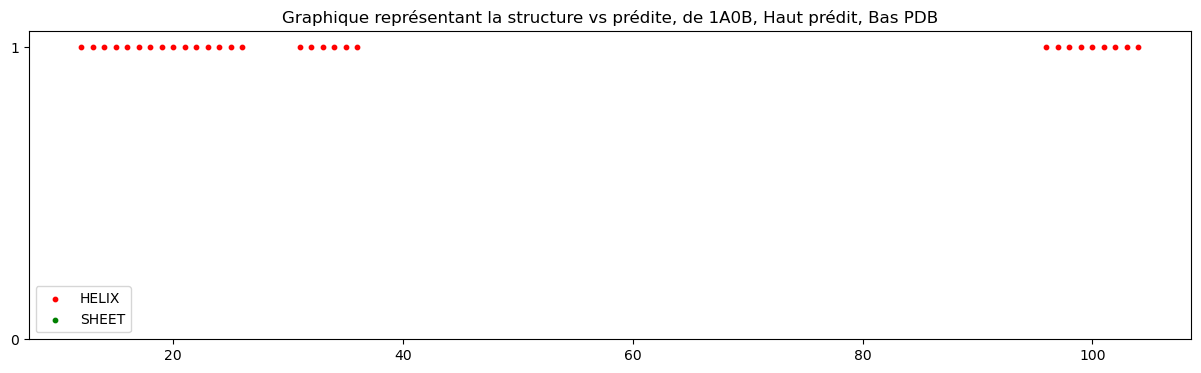

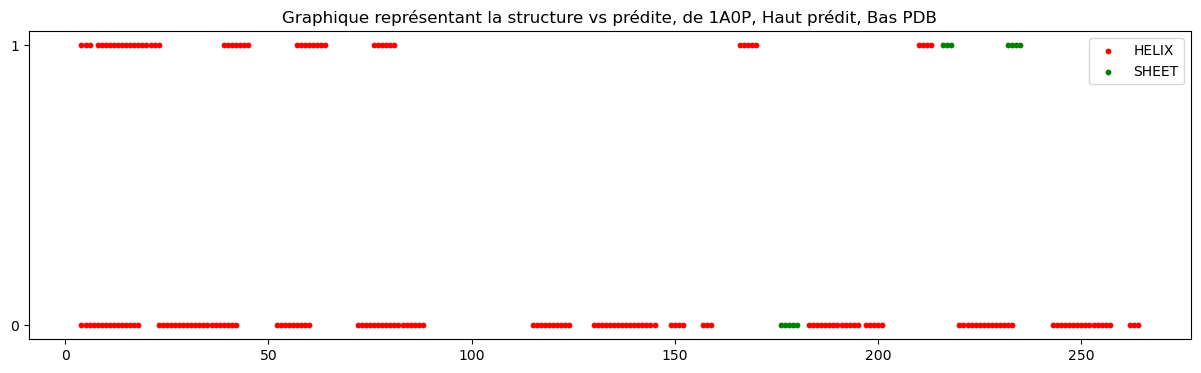

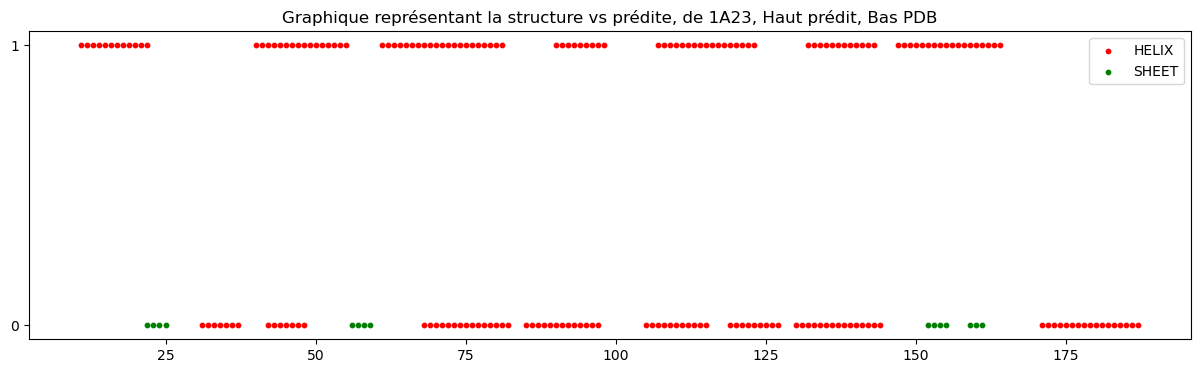

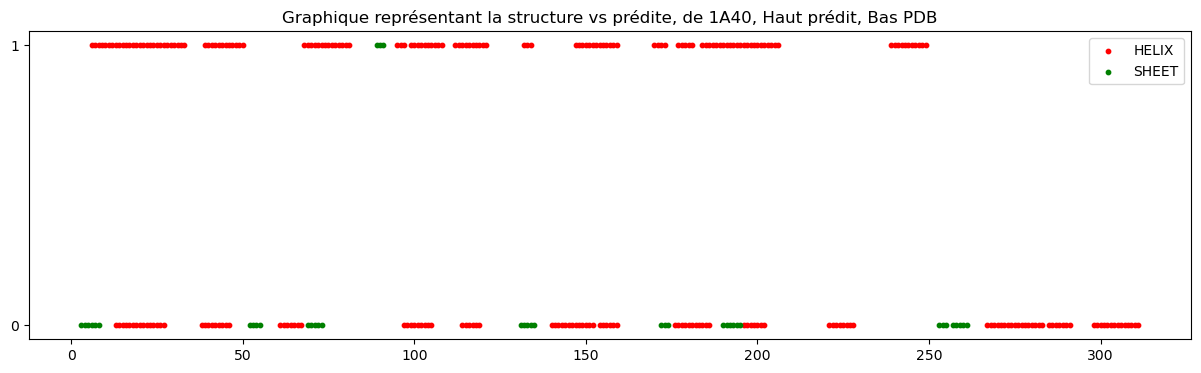

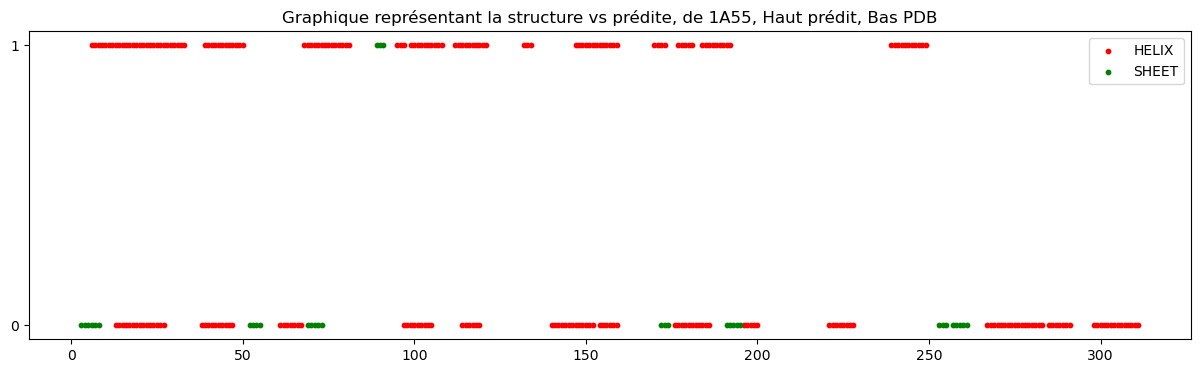

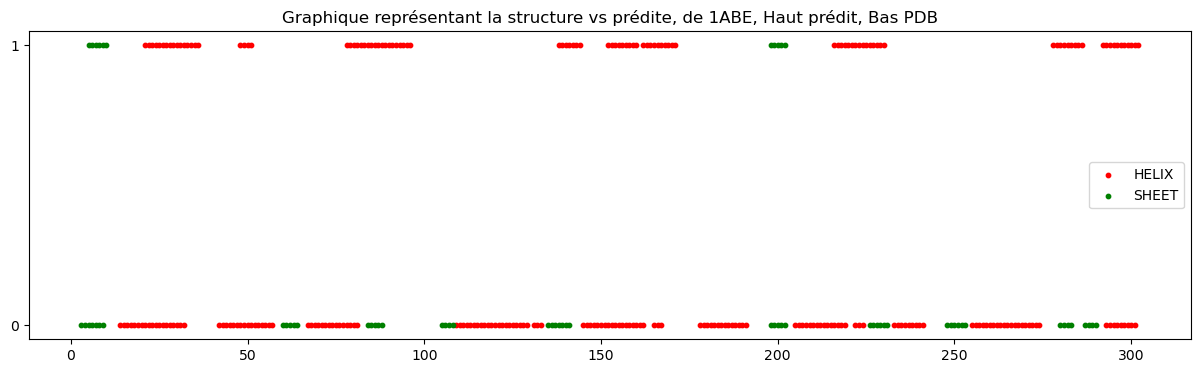

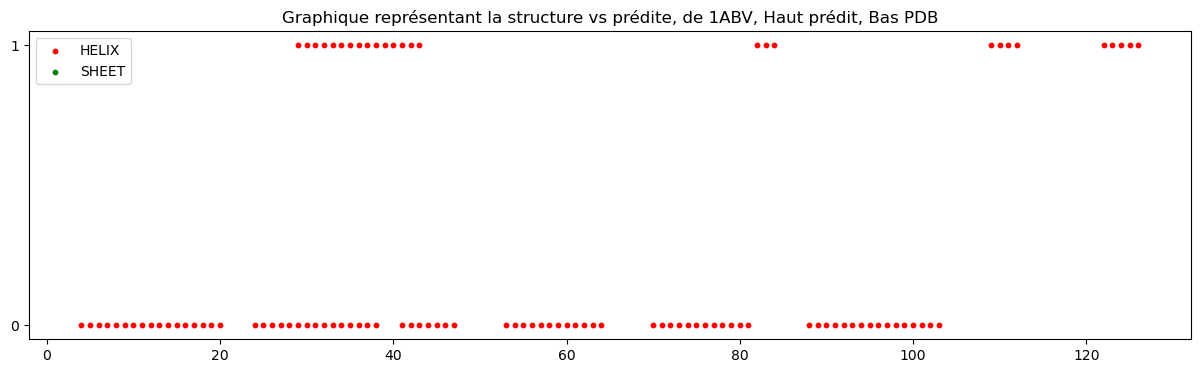

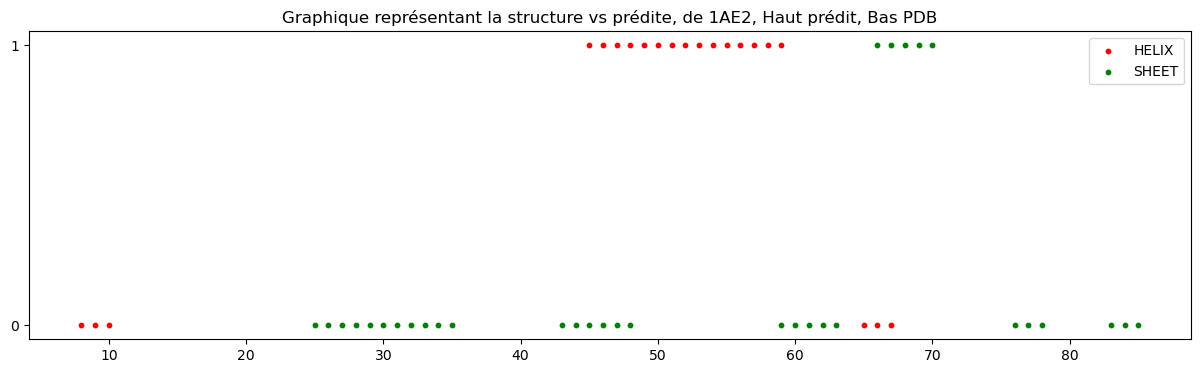

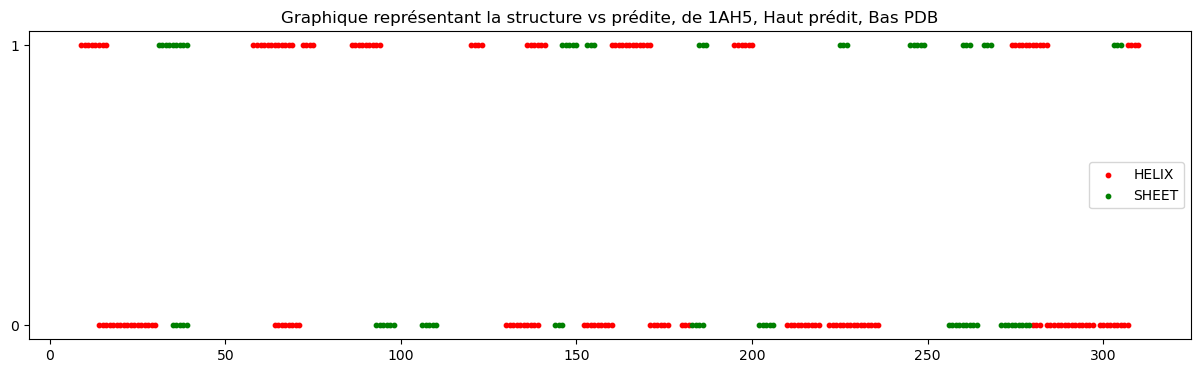

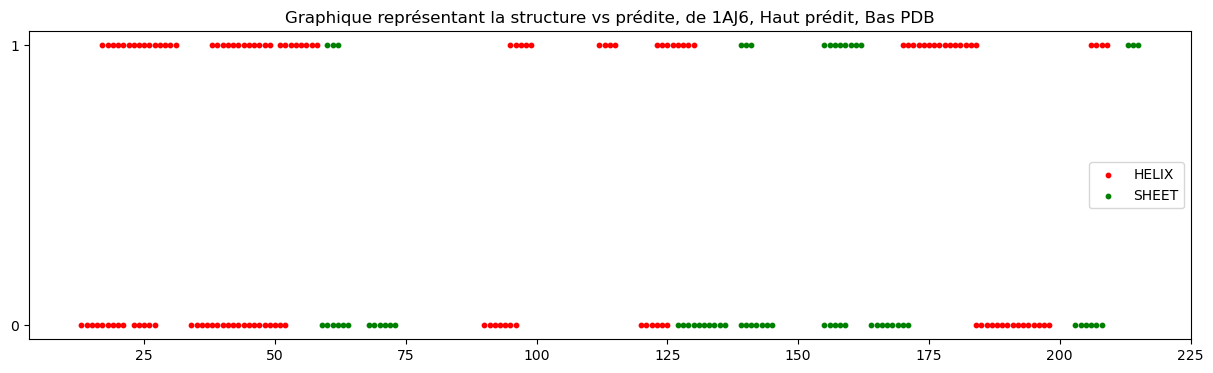

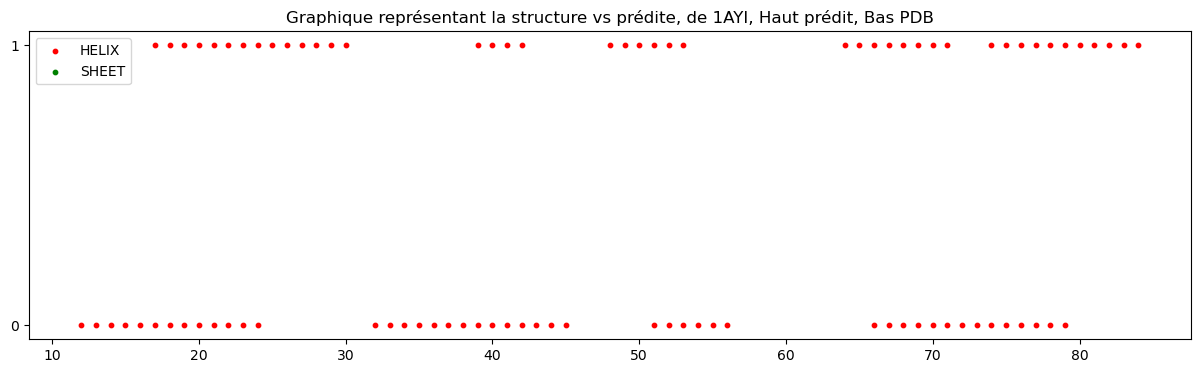

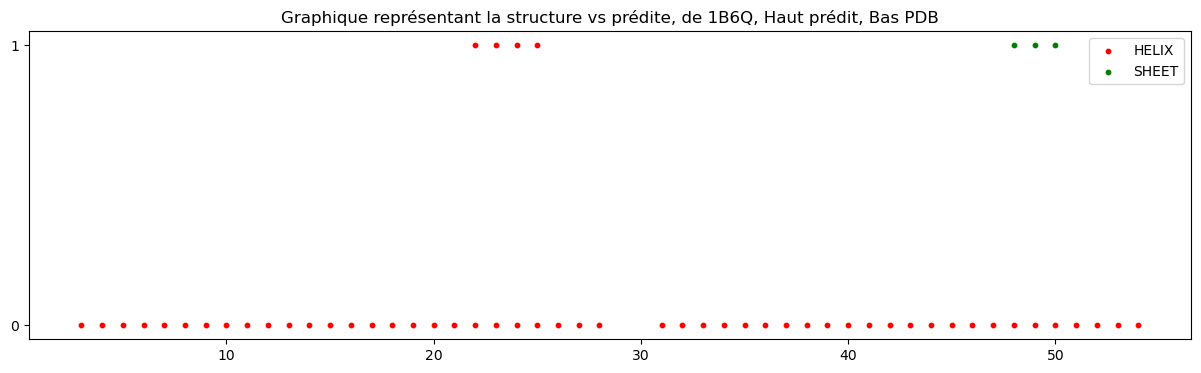

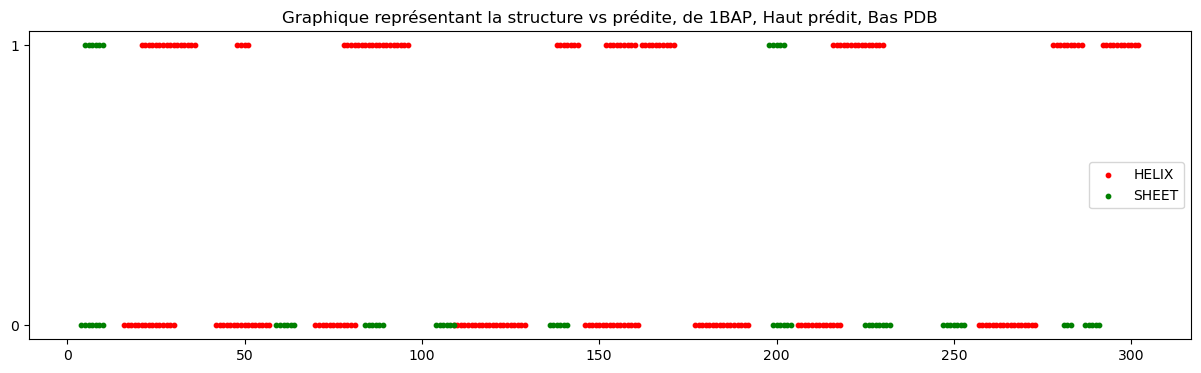

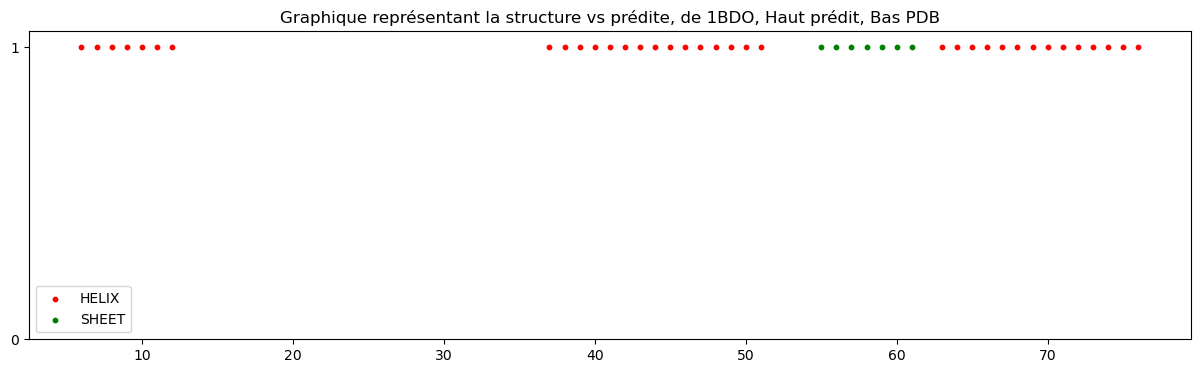

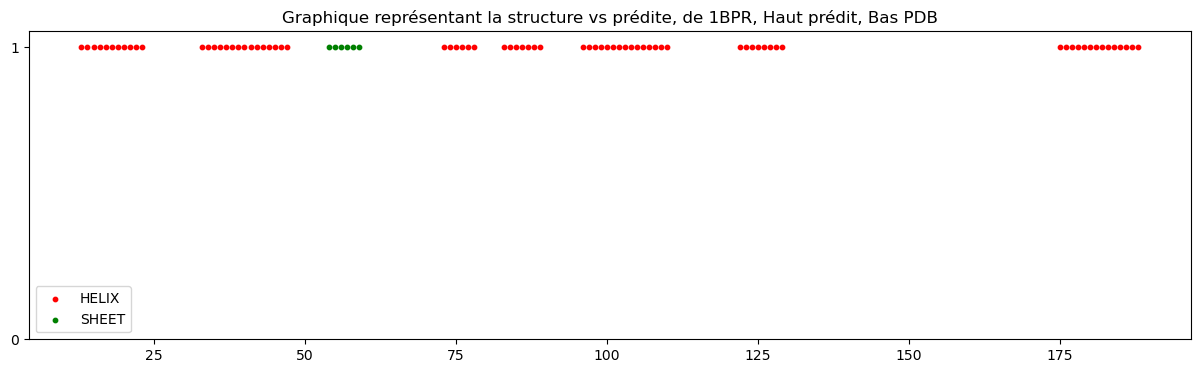

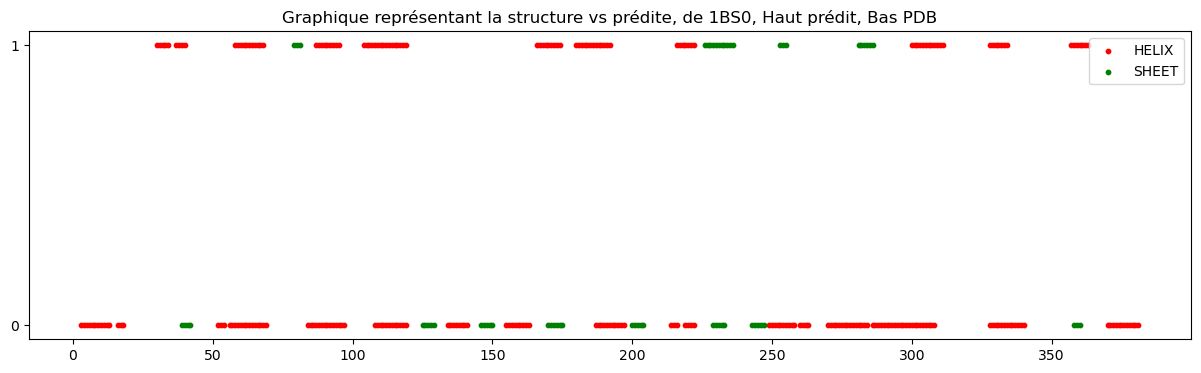

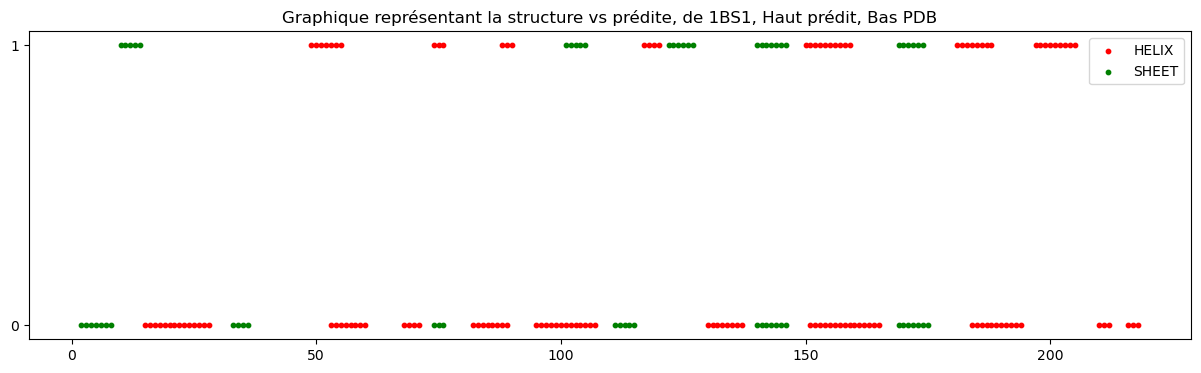

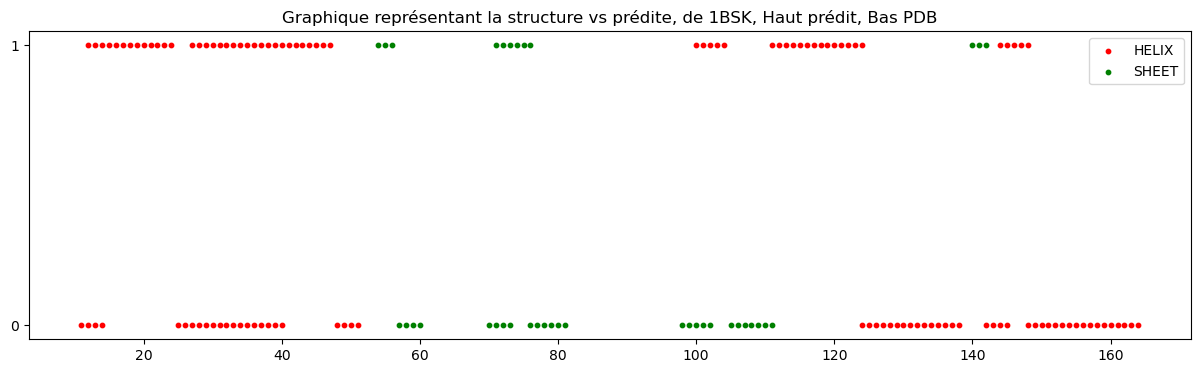

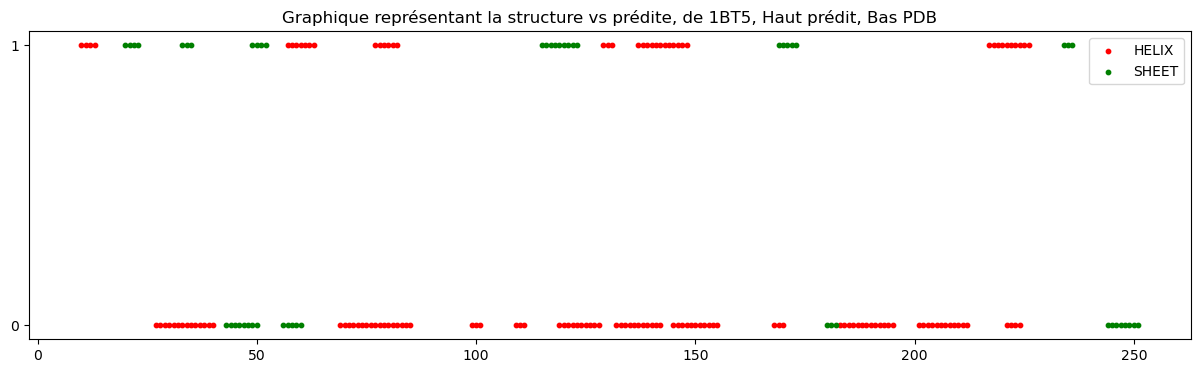

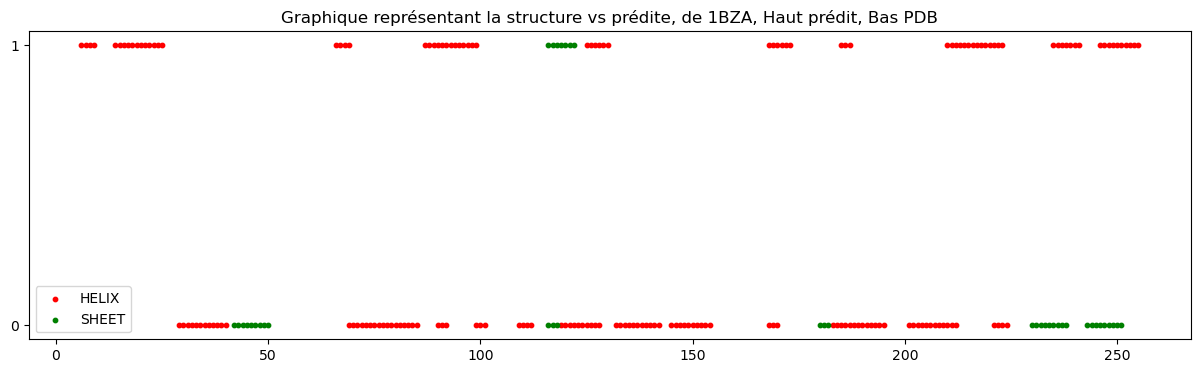

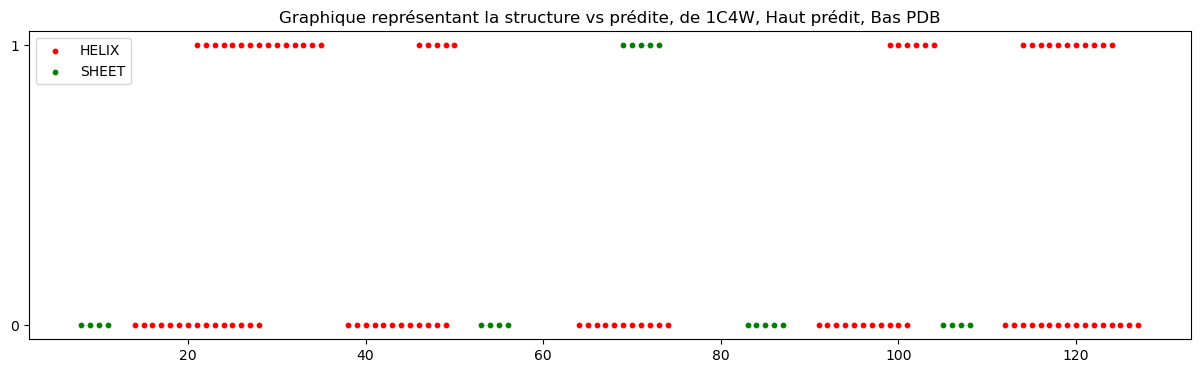

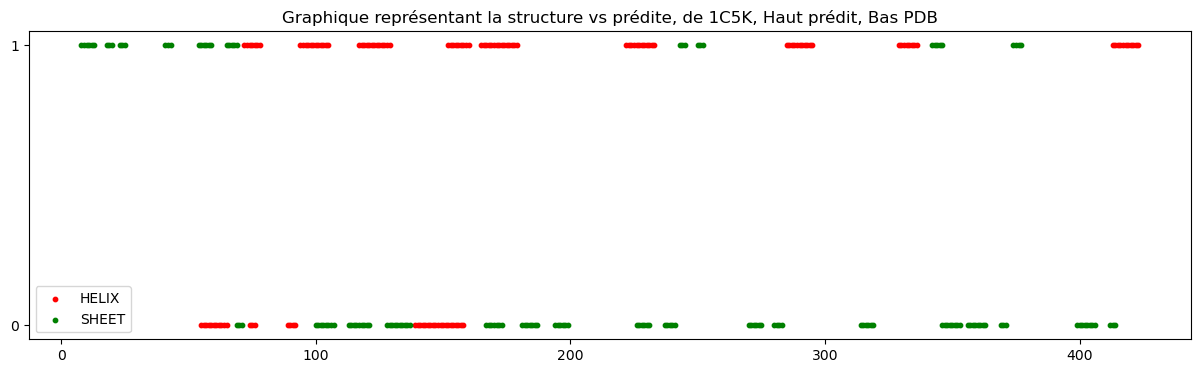

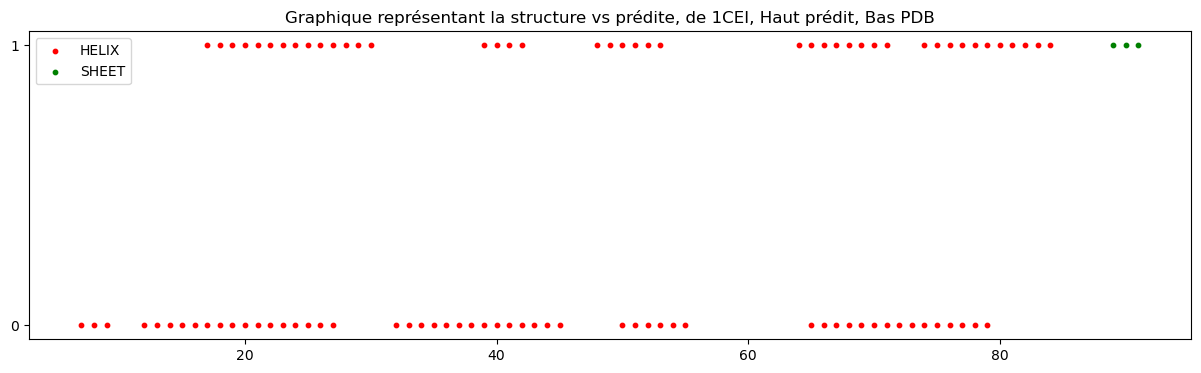

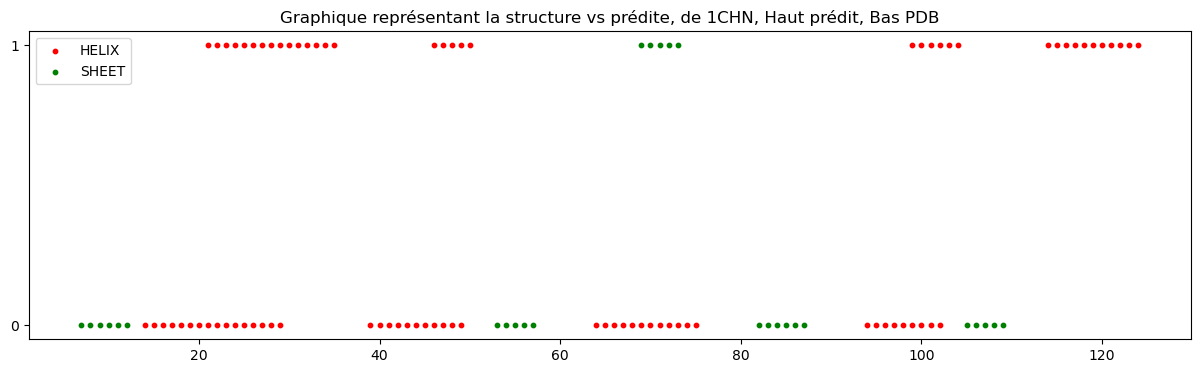

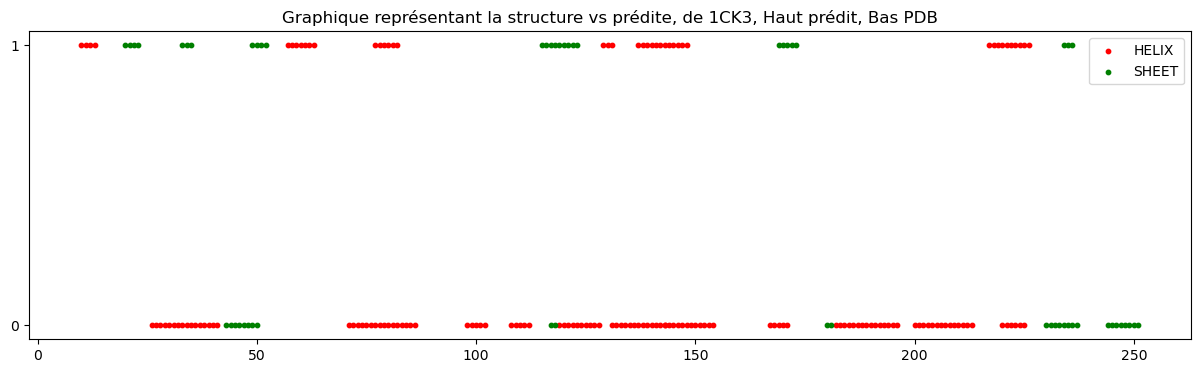

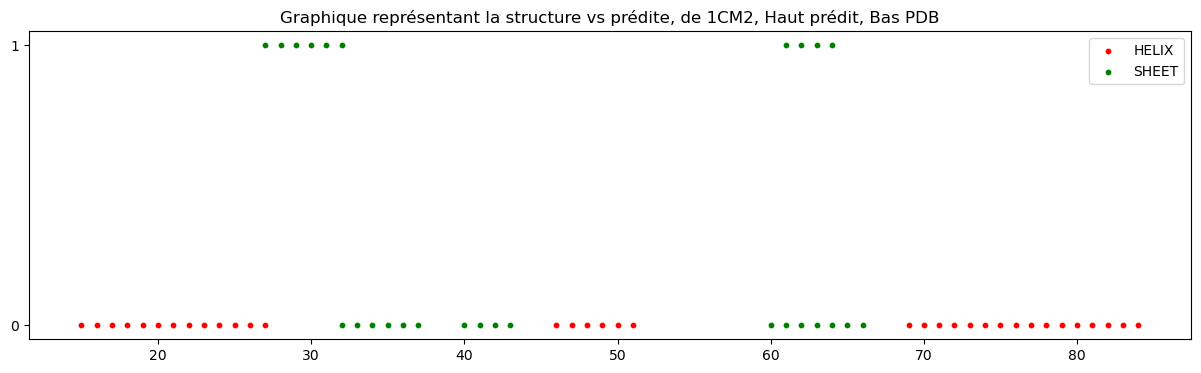

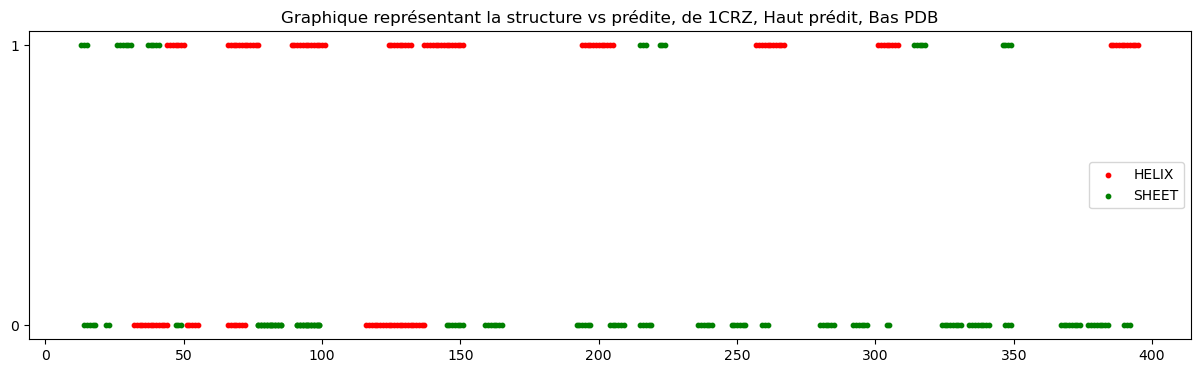

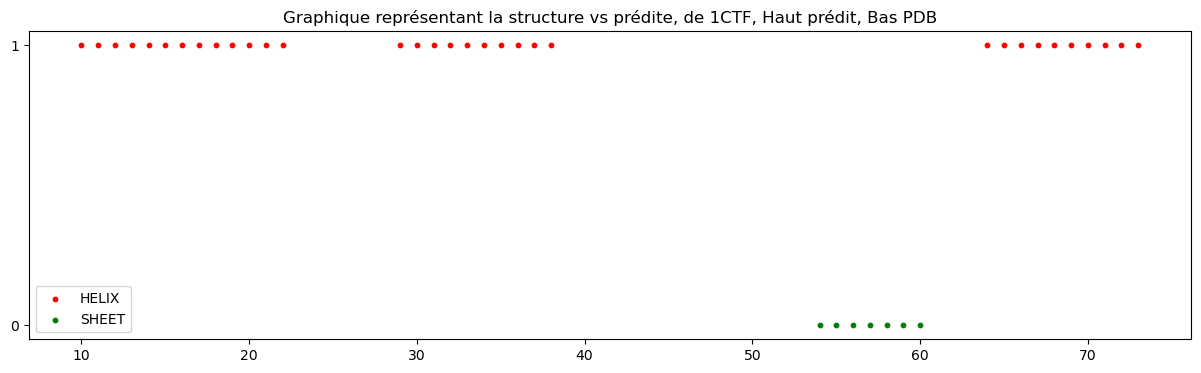

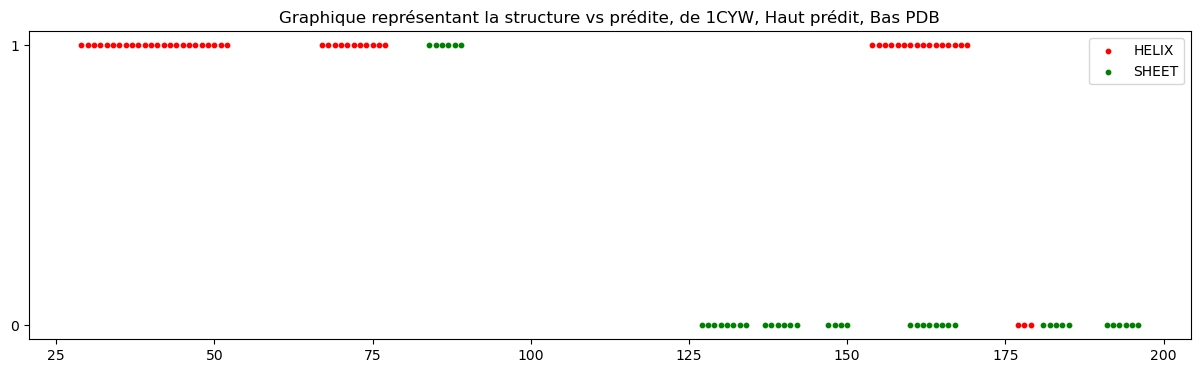

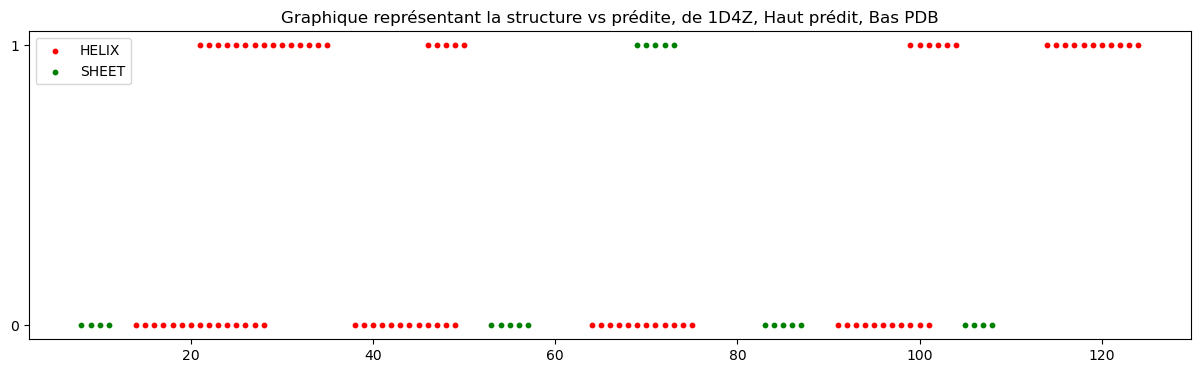

In [53]:
v_knn = table_erreur.iloc[0]['Dimension'][1:-1].replace("'", "").split(', ')
voisins = table_erreur.iloc[0]['Voisin']

points_supervise = []
for _, tup in df[v_knn+['Sequence', 'Structure']].iterrows():
    points_supervise.append(list(tup.values))

print(type(points_supervise[0]))    
    
for pid in os.listdir("Sequence TEST"):
    pid = pid[:-4]
    
    structure_predite, structure, seq = tuple_proteine(en_compte, pid, quali_AA, variables)
    
    x_helix, y_helix = [], []
    x_sheet, y_sheet = [], []
    
    x_helix_predite = []
    x_sheet_predite = []
    
    with open(f"Structure secondaire TEST/{pid}.txt", "r") as filstr:
        for ligne in filstr:
            ligne = ligne[:-1].split(";")
            if ligne[0] == "HELIX" and len(ligne) == 11 and ligne[4] == "A":
                debut, fin = int(ligne[5]), int(ligne[8])
                if debut < fin and debut < len(seq) and fin < len(seq):
                    for i in range(debut-1, fin):
                        y_helix.append(0)
                        x_helix.append(i+1)
            elif ligne[0] == "SHEET" and len(ligne) == 19 and ligne[5] == "A":
                debut, fin = int(ligne[6]), int(ligne[9])
                if debut < fin and debut < len(seq) and fin < len(seq):
                    for i in range(debut-1, fin):
                        y_sheet.append(0)
                        x_sheet.append(i+1)
                        
    all_str = [indice for indice, val in enumerate(structure_predite) if val == "Structure"]
    all_str = trouver_sequences_contigues(all_str)
    
    for intervalle in all_str:
        binf = intervalle[0]
        bsup = intervalle[-1]
        seq_str = ""
        if bsup - binf + 1 > 2:
            for i in range(binf, bsup+1):
                seq_str += seq[i]
            point = []
            for v in v_knn:
                if v == "Taille":
                    point.append(bsup - binf + 1)
                else:
                    moy = 0
                    for acide_amine in seq_str:
                        moy += AA[acide_amine][v]
                    moy /= bsup - binf + 1
                    point.append(moy)
            pred, _ = knn(point, voisins, points_supervise)
            if pred == "HELIX":
                x_helix_predite += list(i for i in range(binf+1, bsup+2))
            else:
                x_sheet_predite += list(i for i in range(binf+1, bsup+2))
    
    fig, ax = plt.subplots(figsize=(15, 4))
    
    ax.scatter(x_helix_predite, [1 for _ in range(len(x_helix_predite))], color='red', s=10)
    ax.scatter(x_sheet_predite, [1 for _ in range(len(x_sheet_predite))], color='green', s=10)
    
    ax.scatter(x_helix, y_helix, color='red', s=10, label="HELIX")
    ax.scatter(x_sheet, y_sheet, color='green', s=10, label="SHEET")

    ax.set_yticks(range(2))

    ax.set_title(f"Graphique représentant la structure vs prédite, de {pid}, Haut prédit, Bas PDB")
    ax.legend()

    plt.show()
    

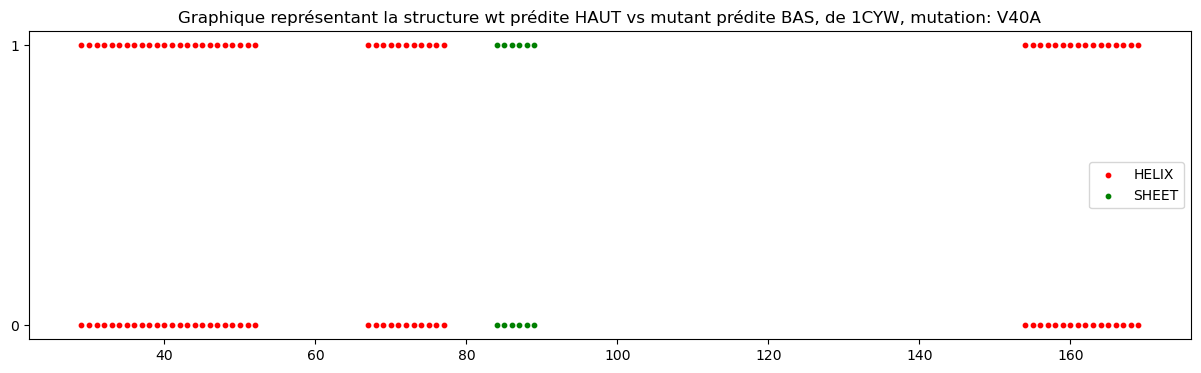

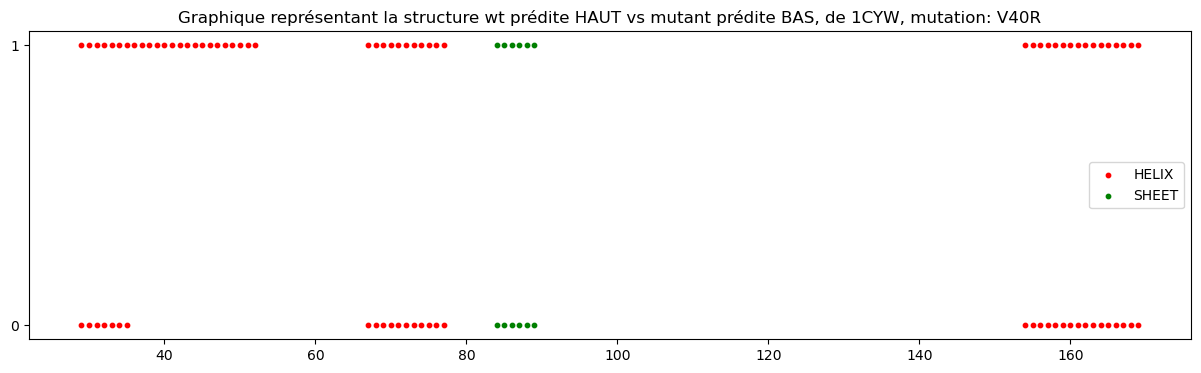

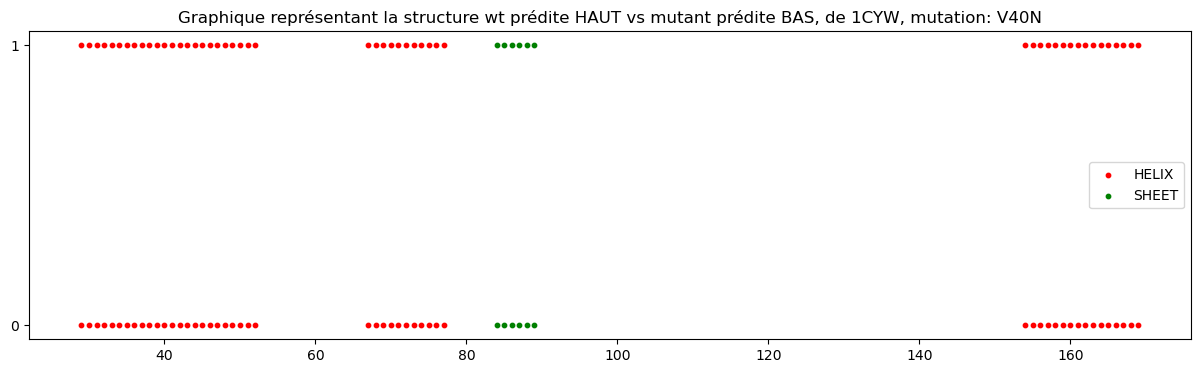

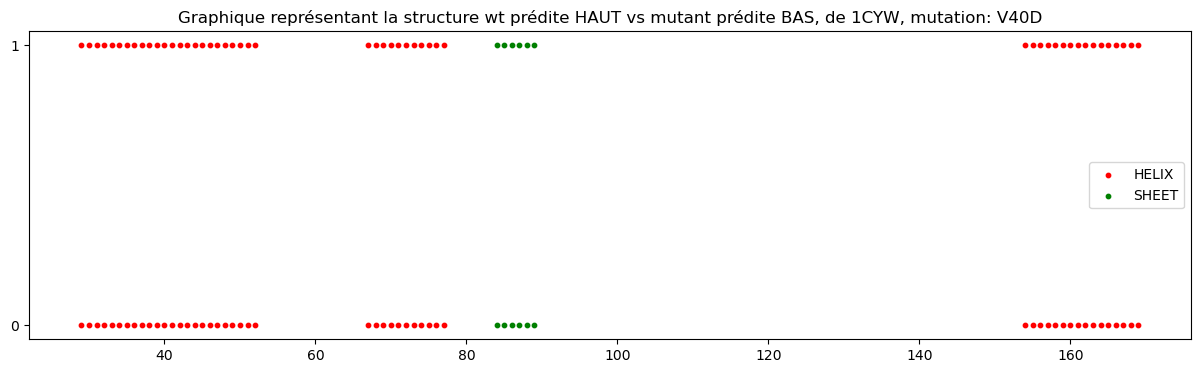

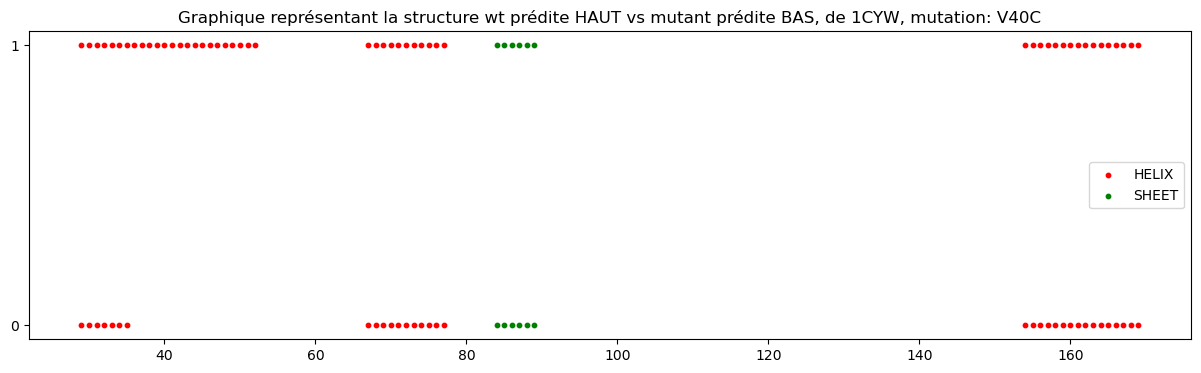

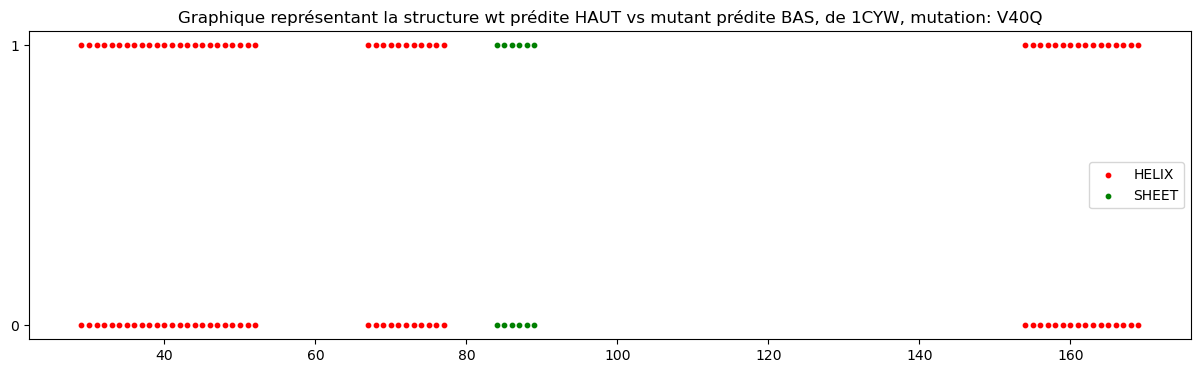

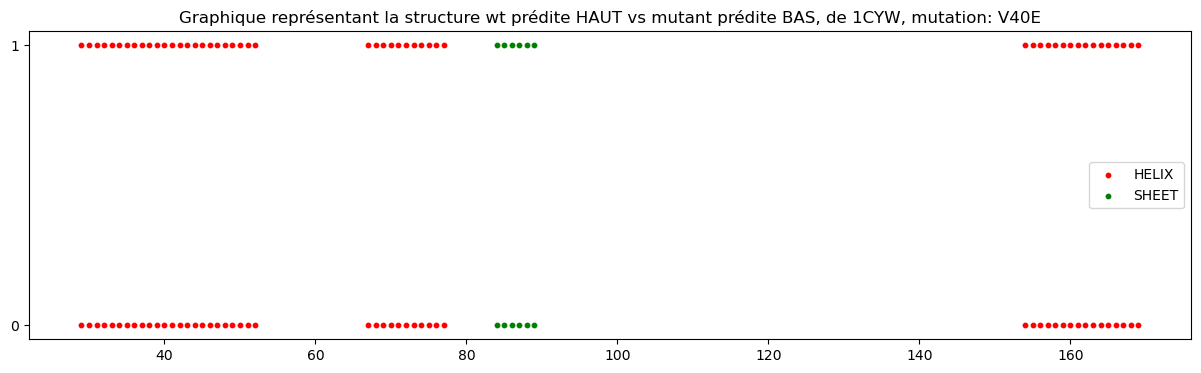

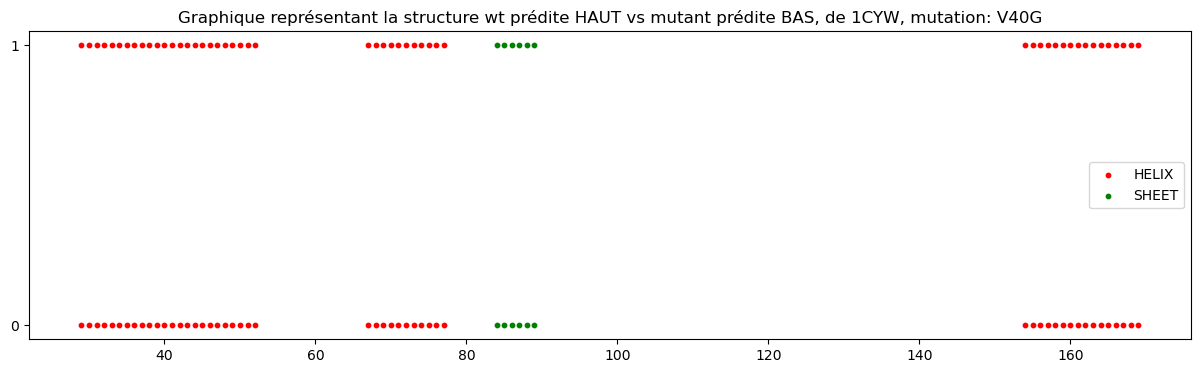

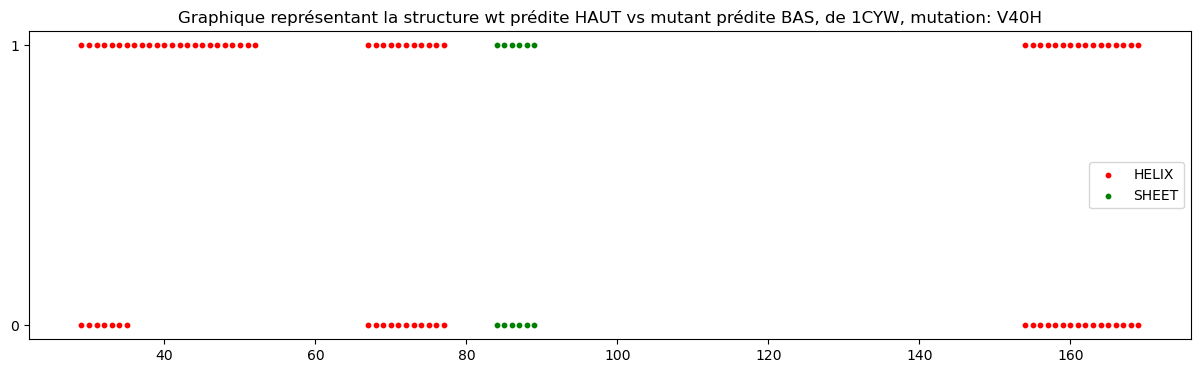

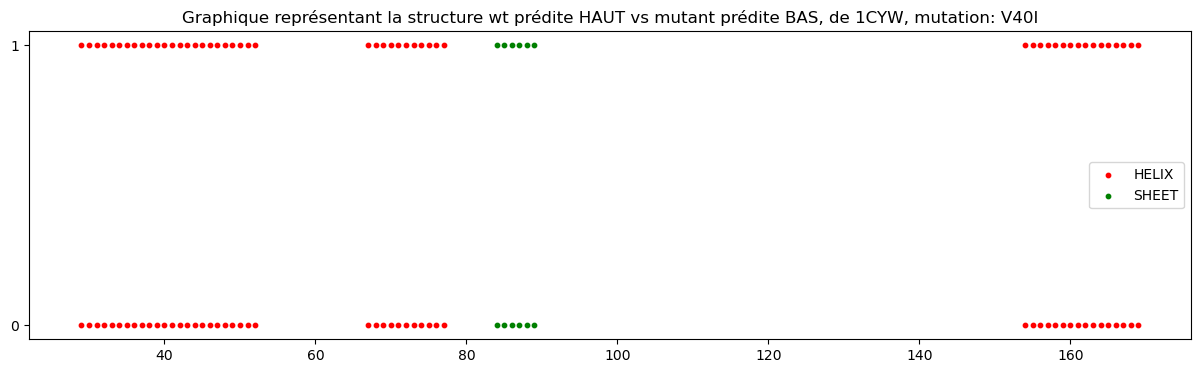

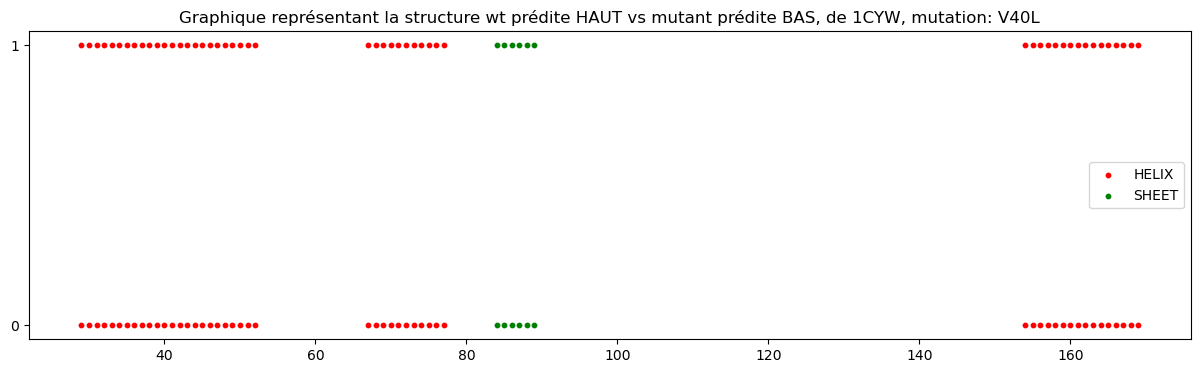

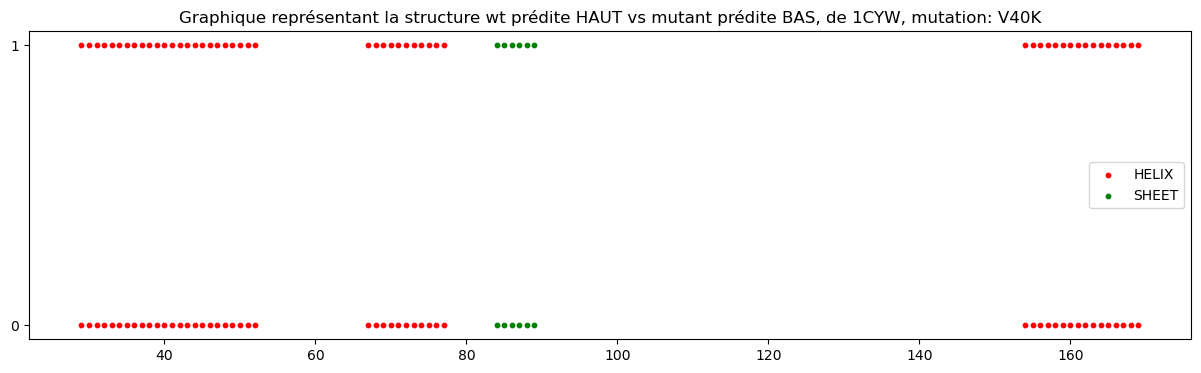

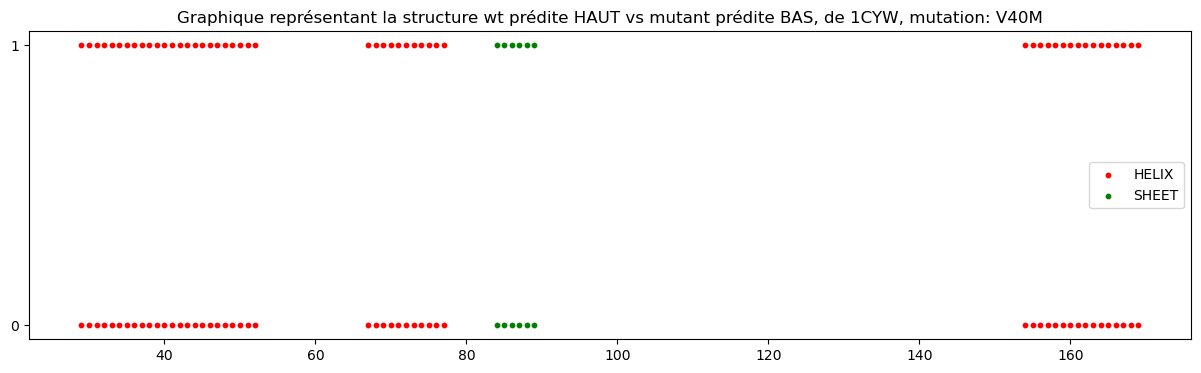

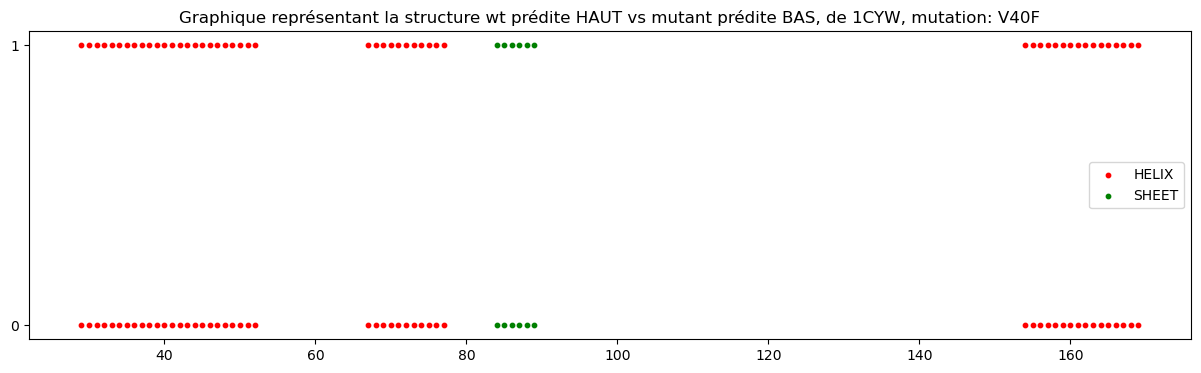

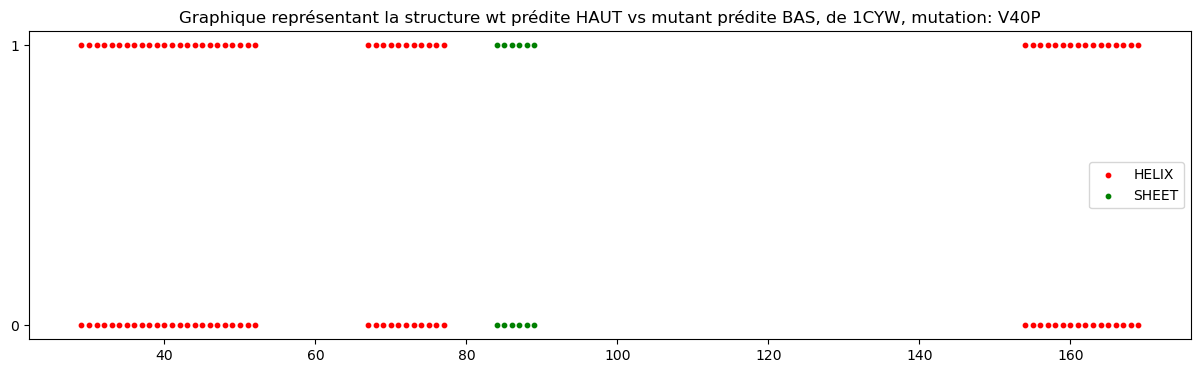

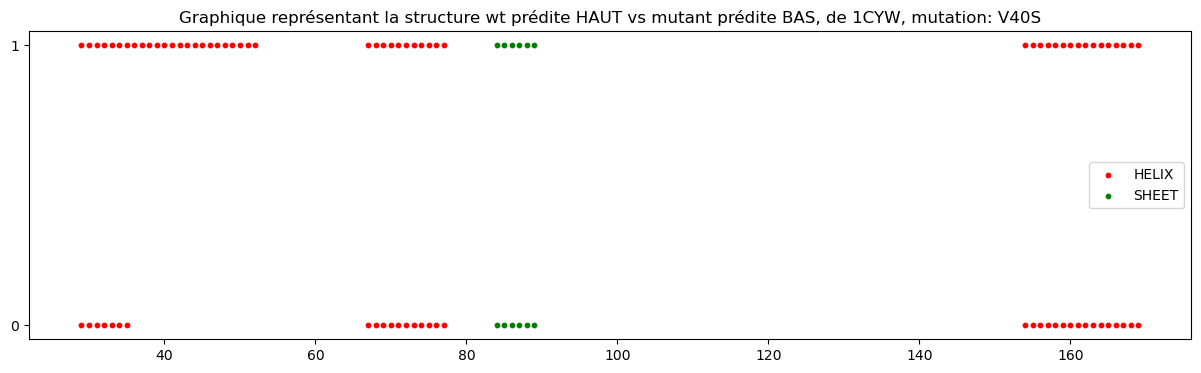

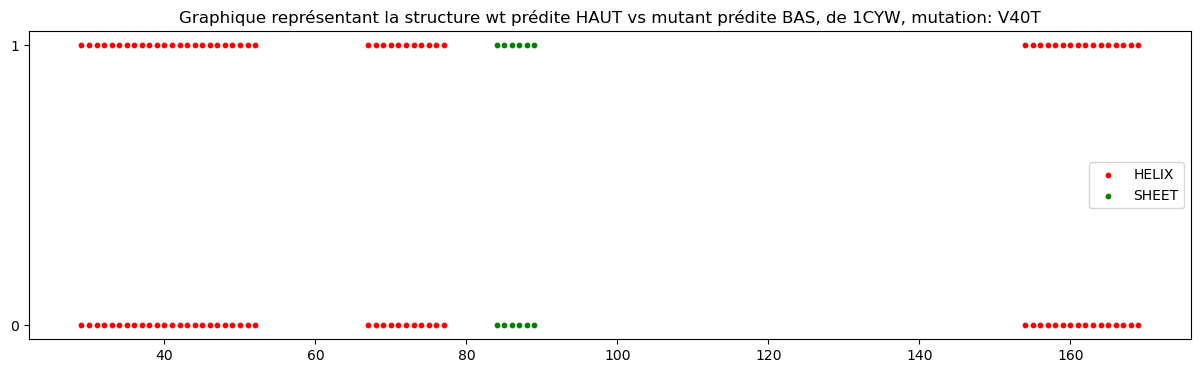

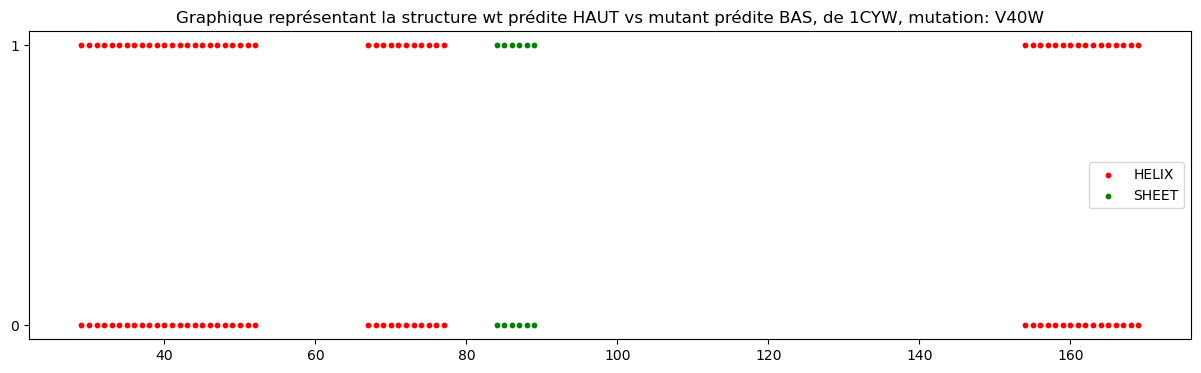

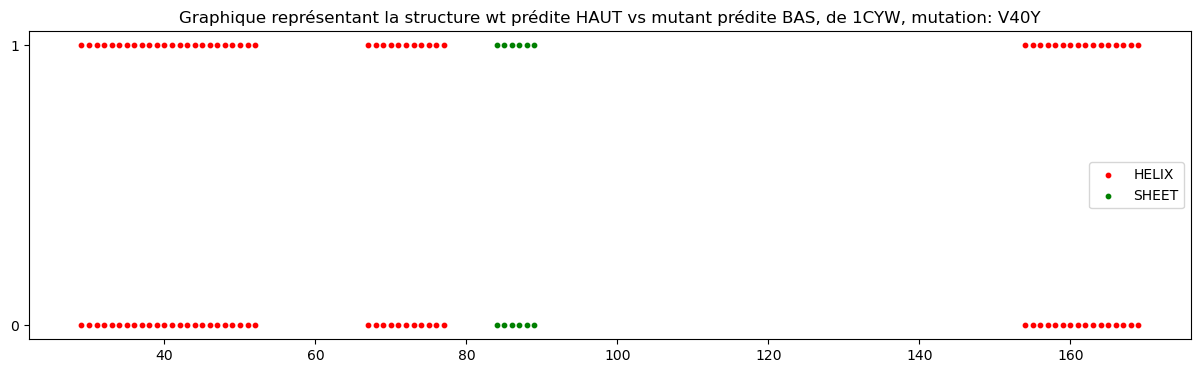

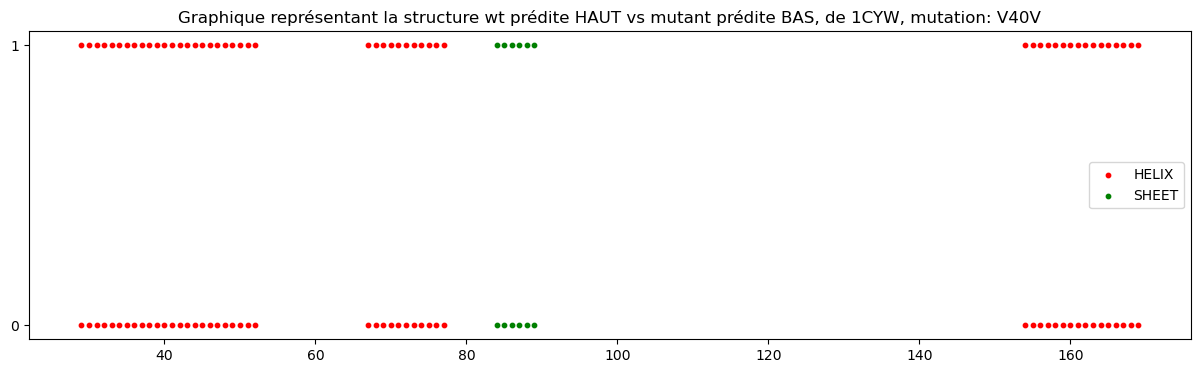

In [54]:
v_knn = table_erreur.iloc[0]['Dimension'][1:-1].replace("'", "").split(', ')
voisins = table_erreur.iloc[0]['Voisin']

pid = "1CYW"
first = True

structure_predite, _, seq = tuple_proteine(en_compte, pid, quali_AA, variables)

x_helix_predite = []
x_sheet_predite = []

all_str = [indice for indice, val in enumerate(structure_predite) if val == "Structure"]
all_str = trouver_sequences_contigues(all_str)

for intervalle in all_str:
    binf = intervalle[0]
    bsup = intervalle[-1]
    seq_str = ""
    if bsup - binf + 1 > 2:
        for i in range(binf, bsup+1):
            seq_str += seq[i]
        point = []
        for v in v_knn:
            if v == "Taille":
                point.append(bsup - binf + 1)
            else:
                moy = 0
                for acide_amine in seq_str:
                    moy += AA[acide_amine][v]
                moy /= bsup - binf + 1
                point.append(moy)
        pred, _ = knn(point, voisins, points_supervise)
        if pred == "HELIX":
            x_helix_predite += list(i for i in range(binf+1, bsup+2))
            if first:
                first = False
                position = (binf+bsup)//2
        else:
            x_sheet_predite += list(i for i in range(binf+1, bsup+2))

for acide_amine in AA.keys():
    
    structure_predite, _, seq_mutant = tuple_proteine_mutation(en_compte, pid, quali_AA, variables, acide_amine, position)
    
    sauvage, mutant = seq[position], acide_amine

    x_helix_predite_mutant = []
    x_sheet_predite_mutant = []

    all_str = [indice for indice, val in enumerate(structure_predite) if val == "Structure"]
    all_str = trouver_sequences_contigues(all_str)

    for intervalle in all_str:
        binf = intervalle[0]
        bsup = intervalle[-1]
        seq_str = ""
        if bsup - binf + 1 > 2:
            for i in range(binf, bsup+1):
                seq_str += seq_mutant[i]
            point = []
            for v in v_knn:
                if v == "Taille":
                    point.append(bsup - binf + 1)
                else:
                    moy = 0
                    for acide_amine in seq_str:
                        moy += AA[acide_amine][v]
                    moy /= bsup - binf + 1
                    point.append(moy)
            pred, _ = knn(point, voisins, points_supervise)
            if pred == "HELIX":
                x_helix_predite_mutant += list(i for i in range(binf+1, bsup+2))
            else:
                x_sheet_predite_mutant += list(i for i in range(binf+1, bsup+2))

    fig, ax = plt.subplots(figsize=(15, 4))

    ax.scatter(x_helix_predite, [1 for _ in range(len(x_helix_predite))], color='red', s=10, label="HELIX")
    ax.scatter(x_sheet_predite, [1 for _ in range(len(x_sheet_predite))], color='green', s=10, label="SHEET")
    
    ax.scatter(x_helix_predite_mutant, [0 for _ in range(len(x_helix_predite_mutant))], color='red', s=10)
    ax.scatter(x_sheet_predite_mutant, [0 for _ in range(len(x_sheet_predite_mutant))], color='green', s=10)

    ax.set_yticks(range(2))

    ax.set_title(f"Graphique représentant la structure wt prédite HAUT vs mutant prédite BAS, de {pid}, mutation: {sauvage}{position+1}{mutant}")
    ax.legend()

    plt.show()

In [55]:
taille_foret = 100
hyp_en_compte = [random.randint(2, 10) for _ in range(taille_foret)]
hyp_taille_apprentissage = [random.randint(100, 500) for _ in range(taille_foret)]

In [56]:
foret = creation_foret(hyp_en_compte, hyp_taille_apprentissage, "Foret num 1")

In [57]:
perf_individuelle = pd.read_csv(resultat_foret_individuelle(foret, "Foret num 1"), sep=";")
perf_individuelle

,Numero,Erreur_structure,Erreur_non_structure,Total
0,1,30.07,17.30,23.33
1,2,25.65,22.13,23.79
2,3,23.46,13.60,18.25
3,4,20.55,13.39,16.77
4,5,24.94,13.48,18.89
...,...,...,...,...
95,96,28.96,17.82,23.07
96,97,27.07,19.75,23.20
97,98,26.93,17.40,21.89
98,99,26.26,16.34,21.02


In [58]:
print(resultat_foret_total(foret, "Foret num 1"))

Structure: 11.41, Non Structure: 10.13, Total: 10.73
